In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
cd ../sim

/home/fernando/S1_netpyne/sim


## cfg

In [3]:
"""
cfg.py 

Simulation configuration for S1 model (using NetPyNE)
This file has sim configs as well as specification for parameterized values in netParams.py 

Contributors: salvadordura@gmail.com, fernandodasilvaborges@gmail.com
"""

from netpyne import specs
import pickle
import os
import numpy as np

cfg = specs.SimConfig()  

#------------------------------------------------------------------------------
#
# SIMULATION CONFIGURATION
#
#------------------------------------------------------------------------------

#------------------------------------------------------------------------------
# Run parameters
#------------------------------------------------------------------------------
cfg.duration = 2.0*1e2 ## Duration of the sim, in ms  
cfg.dt = 0.025
cfg.seeds = {'conn': 4322, 'stim': 4322, 'loc': 4322} 
cfg.hParams = {'celsius': 34, 'v_init': -69.5}  
cfg.verbose = False
cfg.createNEURONObj = True
cfg.createPyStruct = True  
cfg.cvode_active = False
cfg.cvode_atol = 1e-6
cfg.cache_efficient = True
cfg.printRunTime = 0.1

cfg.includeParamsLabel = False
cfg.printPopAvgRates = True
cfg.checkErrors = False

#------------------------------------------------------------------------------
# Cells
#------------------------------------------------------------------------------
cfg.rootFolder = os.getcwd()

# Load cells info from previously saved using netpyne (False: load from HOC BBP files, slower)
cfg.loadcellsfromJSON = True

cfg.poptypeNumber = 61 # max 55 + 6
cfg.celltypeNumber = 213 # max 207 + 6

#------------------------------------------------------------------------------  
#------------------------------------------------------------------------------  
# S1 Cells
# Load 55 Morphological Names and Cell pop numbers -> L1:6 L23:10 L4:12 L5:13 L6:14
# Load 207 Morpho-electrical Names used to import the cells from 'cell_data/' -> L1:14 L23:43 L4:46 L5:52 L6:52
# Create [Morphological,Electrical] = number of cell metype in the sub-pop

with open('../info/anatomy/S1-cells-distributions-Rat.txt') as mtype_file:
    mtype_content = mtype_file.read()       

cfg.popNumber = {}
cfg.cellNumber = {} 
cfg.popLabel = {} 
popParam = []
cellParam = []
cfg.meParamLabels = {} 
cfg.popLabelEl = {} 
cfg.cellLabel = {}

for line in mtype_content.split('\n')[:-1]:
    cellname, mtype, etype, n, m = line.split()
    metype = mtype + '_' + etype[0:3]
    cfg.cellNumber[metype] = int(n)
    cfg.popLabel[metype] = mtype
    cfg.popNumber[mtype] = int(m)
    cfg.cellLabel[metype] = cellname

    if mtype not in popParam:
        popParam.append(mtype)
        cfg.popLabelEl[mtype] = [] 
               
    cfg.popLabelEl[mtype].append(metype)
    
    cellParam.append(mtype + '_' + etype[0:3])
    
cfg.S1pops = popParam[0:55]
cfg.S1cells = cellParam[0:207]

#------------------------------------------------------------------------------  
cfg.popParamLabels = popParam
cfg.cellParamLabels = cellParam

#------------------------------------------------------------------------------  
#------------------------------------------------------------------------------  
#------------------------------------------------------------------------------  

## Run only selected populations (me-types)

# subPopLabels = cfg.S1pops[36:38] # from 0 to 55 is full S1 -> L1:6 L23:10 L4:12 L5:13 L6:14
# subPopLabels = ['L4_PC','L4_LBC','L5_TTPC1','L5_MC'] #
# subPopLabels = ['L23_PC', 'L4_PC', 'L4_SS', 'L4_SP', 
#              'L5_TTPC1', 'L5_TTPC2', 'L5_STPC', 'L5_UTPC',
#              'L6_TPC_L1', 'L6_TPC_L4', 'L6_BPC', 'L6_IPC', 'L6_UTPC']
subPopLabels = cfg.S1pops
#------------------------------------------------------------------------------  
cfg.S1pops = subPopLabels
cfg.S1cells = []
for metype in cfg.cellParamLabels:
    if cfg.popLabel[metype] in subPopLabels:        
        cfg.S1cells.append(metype)
        
cfg.thalamicpops = []

cfg.popParamLabels = cfg.S1pops
cfg.cellParamLabels = cfg.S1cells
#------------------------------------------------------------------------------  
#------------------------------------------------------------------------------  
#------------------------------------------------------------------------------  

#--------------------------------------------------------------------------
# Recording 
#--------------------------------------------------------------------------
cfg.allpops = cfg.cellParamLabels
cfg.cellsrec = 0
if cfg.cellsrec == 0:  cfg.recordCells = cfg.allpops # record all cells
elif cfg.cellsrec == 1: cfg.recordCells = [(pop,0) for pop in cfg.allpops] # record one cell of each pop
elif cfg.cellsrec == 2: # record one cell of each cellMEtype # need more test!!!
    cfg.recordCells = []
    for metype in cfg.cellParamLabels:
        if cfg.cellNumber[metype] < 5:
            for numberME in range(cfg.cellNumber[metype]):
                cfg.recordCells.append((metype,numberME))
        else:
            numberME = 0
            diference = cfg.cellNumber[metype] - 5.0*int(cfg.cellNumber[metype]/5.0)
            
            for number in range(5):            
                cfg.recordCells.append((metype,numberME))
                
                if number < diference:              
                    numberME+=int(np.ceil(cfg.cellNumber[metype]/5.0))  
                else:
                    numberME+=int(cfg.cellNumber[metype]/5.0)

                    
cfg.recordTraces = {'V_soma': {'sec':'soma', 'loc':0.5, 'var':'v'}}  ## Dict with traces to record
cfg.recordStim = False			
cfg.recordTime = False  		
cfg.recordStep = 0.1            

cfg.recordLFP = [[200, 1100, 200], [220, 1100, 200], [200, 1200, 220], [220, 1200, 220]]
cfg.saveLFPPops =  cfg.recordCells 

#------------------------------------------------------------------------------
# Saving
#------------------------------------------------------------------------------
cfg.simLabel = 'LFP2p'
cfg.saveFolder = '../data/'+cfg.simLabel
# cfg.filename =                	## Set file output name
cfg.savePickle = False	        	## Save pkl file
cfg.saveJson = False           	## Save json file
cfg.saveDataInclude = ['simData', 'simConfig', 'netParams', 'net'] ## , 'simConfig', 'netParams'
cfg.backupCfgFile = None 		##  
cfg.gatherOnlySimData = False	##  
cfg.saveCellSecs = True			
cfg.saveCellConns = True	

#------------------------------------------------------------------------------
# Analysis and plotting 
# ------------------------------------------------------------------------------
# cfg.analysis['plotRaster'] = {'include': cfg.allpops, 'saveFig': True, 'showFig': False, 'orderInverse': True, 'timeRange': [0,cfg.duration], 'figSize': (36,18), 'labels': 'legend', 'popRates': True, 'fontSize':12, 'lw': 1, 'markerSize':2, 'marker': '.', 'dpi': 300} 
# cfg.analysis['plot2Dnet']   = {'include': cfg.allpops, 'saveFig': True, 'showConns': False, 'figSize': (24,24), 'fontSize':16}   # Plot 2D cells xy
# cfg.analysis['plotTraces'] = {'include': cfg.recordCells, 'oneFigPer': 'cell', 'overlay': True, 'timeRange': [0,cfg.duration], 'saveFig': True, 'showFig': False, 'figSize':(12,4)}
# cfg.analysis['plot2Dfiring']={'saveFig': True, 'figSize': (24,24), 'fontSize':16}
# cfg.analysis['plotConn'] = {'includePre': cfg.allpops, 'includePost': cfg.allpops, 'feature': 'numConns', 'groupBy': 'pop', 'figSize': (24,24), 'saveFig': True, 'orderBy': 'gid', 'graphType': 'matrix', 'saveData':'../data/v5_batch0/v5_batch0_matrix_numConn.json', 'fontSize': 18}
# cfg.analysis['plotConn'] = {'includePre': ['L1_DAC_cNA','L23_MC_cAC','L4_SS_cAD','L4_NBC_cNA','L5_TTPC2_cAD', 'L5_LBC_cNA', 'L6_TPC_L4_cAD', 'L6_LBC_cNA', 'ss_RTN_o', 'ss_RTN_m', 'ss_RTN_i', 'VPL_sTC', 'VPM_sTC', 'POm_sTC_s1'], 'includePost': ['L1_DAC_cNA','L23_MC_cAC','L4_SS_cAD','L4_NBC_cNA','L5_TTPC2_cAD', 'L5_LBC_cNA', 'L6_TPC_L4_cAD', 'L6_LBC_cNA', 'ss_RTN_o', 'ss_RTN_m', 'ss_RTN_i', 'VPL_sTC', 'VPM_sTC', 'POm_sTC_s1'], 'feature': 'convergence', 'groupBy': 'pop', 'figSize': (24,24), 'saveFig': True, 'orderBy': 'gid', 'graphType': 'matrix', 'fontSize': 18}
# cfg.analysis['plot2Dnet']   = {'include': ['L5_LBC', 'VPM_sTC', 'POm_sTC_s1'], 'saveFig': True, 'showConns': True, 'figSize': (24,24), 'fontSize':16}   # Plot 2D net cells and connections
# cfg.analysis['plotShape'] = {'includePre': cfg.recordCells, 'includePost': cfg.recordCells, 'showFig': False, 'includeAxon': False, 
                            # 'showSyns': False, 'saveFig': True, 'dist': 0.55, 'cvar': 'voltage', 'figSize': (24,12), 'dpi': 600}

# cfg.analysis['plotLFP'] = {'plots': ['timeSeries'], 'figSize': (8,4), 'saveData': False, 'saveFig': True, 'showFig': False} #, 'electrodes': [10], 'maxFreq': 80 'PSD', 'spectrogram'

# cfg.analysis['plotLFP'] = {'separation': 1.0, 'plots': ['timeSeries', 'locations'], 'timeRange': [900,4900], 'electrodes': [ii for ii in range(4)], 'saveFig': True, 'showFig': False}

#------------------------------------------------------------------------------
# Network 
#------------------------------------------------------------------------------
cfg.scale = 1.0 # reduce size
cfg.sizeY = 2082.0
cfg.sizeX = 420.0 # r = 210 um and hexagonal side length = 230.9 um
cfg.sizeZ = 420.0 
cfg.scaleDensity = 1.0/100000.0 #49.0 # Number of cells = 31346

#------------------------------------------------------------------------------
# Current inputs 
#------------------------------------------------------------------------------
cfg.addIClamp = False  # decrease the transient
 
cfg.IClamp = []
cfg.IClampnumber = 0

for popName in cfg.allpops:
    cfg.IClamp.append({'pop': popName, 'sec': 'soma', 'loc': 0.5, 'start': 150, 'dur': 100, 'amp': 0.2}) #pA
    cfg.IClampnumber=cfg.IClampnumber+1


## netParams 

In [4]:

"""
netParams.py

High-level specifications for S1 network model using NetPyNE

Contributors: salvadordura@gmail.com, fernandodasilvaborges@gmail.com
"""

from netpyne import specs
import pandas as pd

netParams = specs.NetParams()   # object of class NetParams to store the network parameters

#------------------------------------------------------------------------------
#
# NETWORK PARAMETERS
#
#------------------------------------------------------------------------------

#------------------------------------------------------------------------------
# General network parameters
#------------------------------------------------------------------------------
netParams.scale = cfg.scale # Scale factor for number of cells
netParams.sizeX = cfg.sizeX # x-dimension (horizontal length) size in um
netParams.sizeY = cfg.sizeY # y-dimension (vertical height or cortical depth) size in um
netParams.sizeZ = cfg.sizeZ # z-dimension (horizontal depth) size in um
netParams.shape = 'cylinder' # cylindrical (column-like) volume
   
# Layer	height (um)	height (norma)	from	to
# L1	165		    0.079		    0.000	0.079
# L2	149		    0.072		    0.079	0.151
# L3	353		    0.170		    0.151	0.320
# L4	190		    0.091		    0.320	0.412
# L5	525		    0.252		    0.412	0.664
# L6	700		    0.336		    0.664	1.000
# L23	502		    0.241		    0.079	0.320
# All	2082	    1.000	


cellModels = ['HH_full']
Epops = ['L23_PC', 'L4_PC', 'L4_SS', 'L4_SP', 
             'L5_TTPC1', 'L5_TTPC2', 'L5_STPC', 'L5_UTPC',
             'L6_TPC_L1', 'L6_TPC_L4', 'L6_BPC', 'L6_IPC', 'L6_UTPC']

Ipops = []
for popName in cfg.S1pops:
    if popName not in Epops:
        Ipops.append(popName)

Epops = []
for popName in cfg.S1pops:
    if popName not in Ipops:
        Epops.append(popName)   

layer = {'1':[0.0, 0.079], '2': [0.079,0.151], '3': [0.151,0.320], '23': [0.079,0.320], '4':[0.320,0.412], '5': [0.412,0.664], '6': [0.664,1.0], 
'longS1': [2.2,2.3], 'longS2': [2.3,2.4]}  # normalized layer boundaries

#------------------------------------------------------------------------------
# General connectivity parameters
#------------------------------------------------------------------------------
netParams.defaultThreshold = -10.0 # spike threshold, 10 mV is NetCon default, lower it for all cells
netParams.defaultDelay = 0.1 # default conn delay (ms)
netParams.propVelocity = 300.0 #  300 μm/ms (Stuart et al., 1997)
netParams.scaleConnWeightNetStims = 0.001  # weight conversion factor (from nS to uS)


#------------------------------------------------------------------------------
# load data from S1 Raster
#------------------------------------------------------------------------------

## Load spkTimes and cells positions
with open('../data/spkTimes_v7_batch0.pkl', 'rb') as fileObj: simData = pickle.load(fileObj)
spkTimes = simData['spkTimes']
cellsTags = simData['cellsTags']

# create custom list of spike times
cellsVSName = {}
popsVSName = {}
for cellLabel in spkTimes.keys():    
    cellme = cellLabel.split('_')[0:-1]    
    metype = cellme[0]
    for i in range(1,np.size(cellme)):
        metype += '_' + cellme[i]
                   
    if metype not in cellsVSName.keys():
        cellsVSName[metype] = []
        
    mtype = cfg.popLabel[metype]    
    if mtype not in popsVSName.keys():
        popsVSName[mtype] = []
        
    cellsVSName[metype].append('presyn_'+cellLabel)
    popsVSName[mtype].append('presyn_'+cellLabel)

# create 1 vectstim pop per S1 cell gid
for popLabel in cellsVSName.keys():
    
    cellsList = []            
    for cellLabel in cellsVSName[popLabel]:

        cellme = cellLabel.split('_')[0:-1]
        metype = cellme[1]
        for i in range(2,np.size(cellme)):
            metype += '_' + cellme[i]         

        if np.size(spkTimes[metype+'_'+cellLabel.split('_')[-1]]) == 0:
            spkTimes[metype+'_'+cellLabel.split('_')[-1]] = [10000.5]
        
        cellsList.append({'cellLabel': int(cellLabel.split('_')[-1]), 'spkTimes': spkTimes[metype+'_'+cellLabel.split('_')[-1]]})
        netParams.popParams['presyn_'+metype] = {'cellModel': 'VecStim', 'cellsList': cellsList}


#------------------------------------------------------------------------------
# Population parameters
#------------------------------------------------------------------------------
## S1

for cellName in cfg.S1cells:
    layernumber = cellName[1:2]
    if layernumber == '2':
        
        netParams.popParams[cellName] = {'cellType': cellName, 'cellModel': 'HH_full', 'ynormRange': layer['23'], 'xnormRange': [0.5-0.5/7.0, 0.5+0.5/7.0],  'znormRange': [0.5-0.5/7.0, 0.5+0.5/7.0], 
                                        'numCells': int(np.ceil(cfg.scaleDensity*cfg.cellNumber[cellName])), 'diversity': True}
      
#         netParams.popParams['L23_PC_cAD'] = {'cellType': cellName, 'cellModel': 'HH_full', 'ynormRange': layer['23'], 'xnormRange': [0.5-0.5/7.0, 0.5+0.5/7.0],  'znormRange': [0.5-0.5/7.0, 0.5+0.5/7.0], 
#                                         'numCells': 1+int(np.ceil(cfg.scaleDensity*cfg.cellNumber[cellName])), 'diversity': True}
    else:

        if cellName not in ['null']:
            netParams.popParams[cellName] = {'cellType': cellName, 'cellModel': 'HH_full', 'ynormRange': layer[layernumber], 'xnormRange': [0.5-0.5/7.0, 0.5+0.5/7.0], 'znormRange': [0.5-0.5/7.0, 0.5+0.5/7.0], 
                                            'numCells': int(np.ceil(cfg.scaleDensity*cfg.cellNumber[cellName])), 'diversity': True}
        else:
            netParams.popParams[cellName] = {'cellType': cellName, 'cellModel': 'HH_full', 'ynormRange': layer[layernumber], 'xnormRange': [0.5-0.5/7.0, 0.5+0.5/7.0], 'znormRange': [0.5-0.5/7.0, 0.5+0.5/7.0], 
                                            'numCells': 1+int(np.ceil(cfg.scaleDensity*cfg.cellNumber[cellName])), 'diversity': True}

            # avoid a error in cell diversity in cellnumber = mult of 5       
        
#------------------------------------------------------------------------------
# Cell parameters  # L1 70  L23 215  L4 230 L5 260  L6 260  = 1035
#------------------------------------------------------------------------------
if not cfg.loadcellsfromJSON:     ## Load cell rules using BBP template
    
    def loadTemplateName(cellMe):     
        outFolder = cfg.rootFolder+'/cell_data/'+cellMe
        try:
            f = open(outFolder+'/template.hoc', 'r')
            for line in f.readlines():
                if 'begintemplate' in line:
                    return str(line)[14:-1]     
        except:
            print('Cannot read cell template from %s' % (outFolder))
            return False

    cellnumber = 0    
    for cellName in cfg.S1cells:

        if cfg.cellNumber[cellName] < 5:
            morphoNumbers = cfg.cellNumber[cellName]
        else:
            morphoNumbers = 5

        for morphoNumber in range(morphoNumbers):
            cellMe = cfg.cellLabel[cellName] + '_' + str(morphoNumber+1)
            print(cellMe,cellName)

            cellTemplateName = loadTemplateName(cellMe)

            if cellTemplateName:

                cellRule = netParams.importCellParams(label=cellMe, somaAtOrigin=True,
                    conds={'cellType': cellMe, 'cellModel': 'HH_full'},
                    fileName='cellwrapper.py',
                    cellName='loadCell',
                    cellInstance = True,
                    cellArgs={'cellName': cellMe, 'cellTemplateName': cellTemplateName})

                netParams.renameCellParamsSec(label=cellMe, oldSec='soma_0', newSec='soma')              
                for secname2 in netParams.cellParams[cellMe]['secLists'].keys():
                 if 'soma_0' in netParams.cellParams[cellMe]['secLists'][secname2]:
                   print(cellMe,secname2,netParams.cellParams[cellMe]['secLists'][secname2][0])
                   netParams.cellParams[cellMe]['secLists'][secname2][0] = 'soma'    

## S1 cell property rules
for cellName in cfg.S1cells:
    
    if cfg.cellNumber[cellName] < 5:
        morphoNumbers = cfg.cellNumber[cellName]
    else:
        morphoNumbers = 5
    
    cellFraction = 1.0/morphoNumbers
    
    for morphoNumber in range(morphoNumbers):
        cellMe = cfg.cellLabel[cellName] + '_' + str(morphoNumber+1)
        
        if cfg.loadcellsfromJSON:
            # Load cell rules previously saved using netpyne format
            netParams.loadCellParamsRule(label = cellMe, fileName = 'cell_data/' + cellMe + '/' + cellMe + '_cellParams.json')        
#             netParams.loadCellParamsRule(label = cellMe, fileName = 'cell_data/L5_TTPC1_cADpyr232_5/L5_TTPC1_cADpyr232_5_cellParams.json')       
        else:
            cellRule = {'conds': {'cellType': cellName}, 'diversityFraction': cellFraction, 'secs': {}}  # cell rule dict
            cellRule['secs'] = netParams.cellParams[cellMe]['secs']     
            cellRule['conds'] = netParams.cellParams[cellMe]['conds']    
            cellRule['conds']['cellType'] = cellName
            cellRule['globals'] = netParams.cellParams[cellMe]['globals']       
            cellRule['secLists'] = netParams.cellParams[cellMe]['secLists']      
            cellRule['secLists']['spiny'] = {}
            cellRule['secLists']['spinyEE'] = {}
            nonSpiny = ['axon_0', 'axon_1']
            cellRule['secLists']['spiny'] = [sec for sec in cellRule['secLists']['all'] if sec not in nonSpiny]
            nonSpinyEE = ['axon_0', 'axon_1', 'soma']
            cellRule['secLists']['spinyEE'] = [sec for sec in cellRule['secLists']['all'] if sec not in nonSpinyEE]
            netParams.cellParams[cellMe] = cellRule   # add dict to list of cell params  

            
# Syns
netParams.synMechParams['AMPA'] = {'mod':'MyExp2SynBB', 'tau1': 0.2, 'tau2': 1.74, 'e': 0}
netParams.synMechParams['NMDA'] = {'mod': 'MyExp2SynNMDABB', 'tau1NMDA': 0.29, 'tau2NMDA': 43, 'e': 0}
netParams.synMechParams['GABAA'] = {'mod':'MyExp2SynBB', 'tau1': 0.2, 'tau2': 8.3, 'e': -80}
netParams.synMechParams['GABAB'] = {'mod':'MyExp2SynBB', 'tau1': 3.5, 'tau2': 260.9, 'e': -93} 

#------------------------------------------------------------------------------    
# Current inputs (IClamp)
#------------------------------------------------------------------------------
if cfg.addIClamp:
     for j in range(cfg.IClampnumber):
        key ='IClamp'
        params = getattr(cfg, key, None)
        key ='IClamp'+str(j+1)
        params = params[j]
        [pop,sec,loc,start,dur,amp] = [params[s] for s in ['pop','sec','loc','start','dur','amp']]

        # add stim source
        netParams.stimSourceParams[key] = {'type': 'IClamp', 'delay': start, 'dur': dur, 'amp': amp}
        
        # connect stim source to target
        netParams.stimTargetParams[key+'_'+pop] =  {
            'source': key, 
            'conds': {'pop': pop},
            'sec': sec, 
            'loc': loc}

In [5]:
np.size(list(cellsVSName.keys()))

207

In [6]:
np.size(list(popsVSName.keys()))

55

In [7]:
np.size(list(netParams.popParams.keys()))

414

In [8]:
#------------------------------------------------------------------------------
# load data from S1 conn pre-processing file 
#------------------------------------------------------------------------------
with open('conn/conn.pkl', 'rb') as fileObj: connData = pickle.load(fileObj)

lmat = connData['lmat']
a0mat = connData['a0mat']
d0 = connData['d0']

a0e = connData['a0mat_exp']
l0e = connData['lmat_exp']
d0e = connData['d0_exp']

a0g = connData['a0mat_gauss']
x0g = connData['x0_gauss']
l0g = connData['lmat_gauss']
d0g = connData['d0_gauss']

dfinal = connData['dfinal']
pmat = {}
pmat[12.5] = connData['pmat12um']
pmat[25] = connData['pmat25um']
pmat[50] = connData['pmat50um']
pmat[75] = connData['pmat75um']
pmat[100] = connData['pmat100um']
pmat[125] = connData['pmat125um']
pmat[150] = connData['pmat150um']
pmat[175] = connData['pmat175um']
pmat[200] = connData['pmat200um'] #max value for d0=200

synperconnNumber = connData['synperconnNumber']
connNumber = connData['connNumber']
decay = connData['decay']
gsyn = connData['gsyn']
use = connData['use']

ConnTypesNumber = connData['ConnTypesNumber'] 
ConnTypes = connData['ConnTypes']   

connIEtype = connData['connIEtype']  
connEItype = connData['connEItype']
parameters_syn = connData['parameters_syn']

physColumnNames = []
syntypes = []
for name,syntype in parameters_syn:    
    if name not in physColumnNames:
        physColumnNames.append(name) 
    if syntype not in syntypes:
        syntypes.append(syntype)
        
dfS6 = pd.DataFrame(index=syntypes, columns=physColumnNames)
for syntype in syntypes:
    for name in physColumnNames:    
        dfS6.loc[syntype][name] = parameters_syn[name,syntype]

#------------------------------------------------------------------------------
# Synaptic mechanism parameters
#------------------------------------------------------------------------------
#  mods from S1 BBP - deterministic version
for syntype in syntypes:
    if syntype > 50:  # Exc
        
        netParams.synMechParams['S1_EE_STP_Det_' + str(syntype)] = {'mod': 'DetAMPANMDA',
                                         'Use': dfS6['use'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['dep'][syntype], # ± dfS6['depStd'][syntype] 
                                         'Fac': dfS6['fac'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_AMPA': 1.74, # ± 0.18 ms
                                         'tau_r_AMPA': 0.2, 
                                         'tau_r_NMDA': 0.29,
                                         'tau_d_NMDA': 43,   
                                         'NMDA_ratio': 0.8, # ± 0.1 for EE -- experimentally measured for some path?
                                         'mg':1.0, #    0.5mM where exceptionally specified?                                                                
                                            }
        netParams.synMechParams['S1_EI_STP_Det_' + str(syntype)] = {'mod': 'DetAMPANMDA',
                                         'Use': dfS6['use'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['dep'][syntype], # ± dfS6['depStd'][syntype] 
                                         'Fac': dfS6['fac'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_AMPA': 1.74, # ± 0.18 ms
                                         'tau_r_AMPA': 0.2,
                                         'tau_r_NMDA': 0.29,
                                         'tau_d_NMDA': 43,   
                                         'NMDA_ratio': 0.4, # ± 0.1  for EI -- experimentally measured for some path?
                                         'mg':1.0, #    0.5mM where exceptionally specified?                                                                
                                            }
    else: # Inh
        
        netParams.synMechParams['S1_II_STP_Det_' + str(syntype)] = {'mod': 'DetGABAAB',
                                         'Use': dfS6['use'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['dep'][syntype], # ± dfS6['depStd'][syntype]  
                                         'Fac': dfS6['fac'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_GABAA': dfS6['decay'][syntype], # ± dfS6['decayStd'][syntype]
                                         'tau_r_GABAA': 0.2,   #rng.lognormal(0.2, 0.1) in synapses.hoc  
                                         'tau_d_GABAB': 260.9,
                                         'tau_r_GABAB': 3.5,
#                                          'GABAB_ratio': 1.0,  #=0(1):The ratio of GABAB to GABAA  ?          
                                            }
        
        netParams.synMechParams['S1_IE_STP_Det_' + str(syntype)] = {'mod': 'DetGABAAB',
                                         'Use': dfS6['use'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['dep'][syntype], # ± dfS6['depStd'][syntype]  
                                         'Fac': dfS6['fac'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_GABAA': dfS6['decay'][syntype], # ± dfS6['decayStd'][syntype]
                                         'tau_r_GABAA': 0.2,   #rng.lognormal(0.2, 0.1) in synapses.hoc  
                                         'tau_d_GABAB': 260.9,
                                         'tau_r_GABAB': 3.5,
#                                          'GABAB_ratio': 1.0,  #=0(1):The ratio of GABAB to GABAA   ?       
                                            }

# Th NEW
#E2 -> syn 134
netParams.synMechParams['TC:S1'] = {'mod': 'DetAMPANMDA',
                                          'Dep': 227.0,
                                          'Fac': 13.0,
                                          'Use': 0.72,
                                          'tau_r_AMPA': 0.2,
                                          'tau_d_AMPA': 1.74,
                                          'NMDA_ratio': 0.4,
                                          'tau_r_NMDA': 0.29,
                                          'tau_d_NMDA': 43.0}


# Spont and BG
netParams.synMechParams['AMPA'] = {'mod':'MyExp2SynBB', 'tau1': 0.2, 'tau2': 1.74, 'e': 0}
netParams.synMechParams['NMDA'] = {'mod': 'MyExp2SynNMDABB', 'tau1NMDA': 0.29, 'tau2NMDA': 43, 'e': 0}
netParams.synMechParams['GABAA'] = {'mod':'MyExp2SynBB', 'tau1': 0.2, 'tau2': 8.3, 'e': -80}
netParams.synMechParams['GABAB'] = {'mod':'MyExp2SynBB', 'tau1': 3.5, 'tau2': 260.9, 'e': -93} 
ESynMech = ['AMPA', 'NMDA']
ISynMech = ['GABAA', 'GABAB']

In [9]:
cfg.addConn = True

cfg.synWeightFractionEE = [1.0, 1.0] # E -> E AMPA to NMDA ratio
cfg.synWeightFractionEI = [1.0, 1.0] # E -> I AMPA to NMDA ratio
cfg.synWeightFractionII = [1.0, 1.0]  # I -> I GABAA to GABAB ratio
cfg.synWeightFractionIE = [1.0, 1.0]  # I -> E GABAA to GABAB ratio
cfg.EEGain = 1.0
cfg.EIGain = 1.0
cfg.IIGain = 1.0
cfg.IEGain = 1.0

In [10]:
netParams.popParams['presyn_L5_MC_bAC']

{'cellModel': 'VecStim',
 'cellsList': [{'cellLabel': 12953, 'spkTimes': [10000.5]},
  {'cellLabel': 12954, 'spkTimes': [10000.5]},
  {'cellLabel': 12955, 'spkTimes': [10000.5]},
  {'cellLabel': 12956, 'spkTimes': [10000.5]},
  {'cellLabel': 12957, 'spkTimes': [10000.5]},
  {'cellLabel': 12958,
   'spkTimes': [50.32500000010288,
    836.550000000952,
    3763.87499998039,
    4558.074999968833,
    5301.12499995802,
    6076.174999946742,
    6885.79999993496,
    7866.174999920694,
    8714.22499994635,
    9781.025000008445]},
  {'cellLabel': 12959,
   'spkTimes': [834.3250000009439,
    2622.4749999969995,
    4555.124999968876,
    5298.324999958061,
    6070.749999946821,
    7861.62499992076,
    8712.449999946246]},
  {'cellLabel': 12960, 'spkTimes': [10000.5]},
  {'cellLabel': 12961, 'spkTimes': [10000.5]},
  {'cellLabel': 12962, 'spkTimes': [10000.5]},
  {'cellLabel': 12963, 'spkTimes': [10000.5]},
  {'cellLabel': 12964, 'spkTimes': [6077.049999946729]},
  {'cellLabel': 12965,

In [11]:
np.size(list(popsVSName.keys()))

55

In [12]:
#------------------------------------------------------------------------------
# S1 Local connectivity parameters 
#------------------------------------------------------------------------------
contA = 0

if cfg.addConn:    
    for pre in Ipops+Epops:
        for post in Ipops+Epops:
            if float(connNumber[pre][post]) > 0:           
                # ------------------------------------------------------------------------------    
                #  2D distance prob rules
                # ------------------------------------------------------------------------------ 
                if int(float(d0[pre][post])) < 25:    # single fit
                    if 'exp' in connData['best_fit'][pre][post]:  # exponential            
                        prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s)' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post])      
                    else: # gaussian
                        prob = '%s*exp(-(dist_2D-%s)**2/(2*%s**2))*(dist_2D<%s)' % (a0g[pre][post],x0g[pre][post],l0g[pre][post],dfinal[pre][post])   
                        
                else:
                    if 'expl' in connData['best_fit'][pre][post]:  # exponential + linear interpolation [25:d0]
                        if int(float(d0[pre][post])) == 25:    #d0==25 -> exponential fit when dist_2D>25, else prob[0um:25um] = pmat[12.5]
                            prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post],d0[pre][post],float(pmat[12.5][pre][post]))
                        else:    #d0>25 -> exponential fit when dist_2D>d0, else prob[0um:d0] = linear interpolation [25:d0]
                            d01 = int(float(d0[pre][post]))
                            y1 = float(pmat[25][pre][post])
                            y2 = float(pmat[d01][pre][post])
                            x1 = 25
                            x2 = d01                   
                            angular = (y2 - y1)/(x2 - x1)
                            linear = y2 - x2*angular
                            prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f * dist_2D + %f' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post],d0[pre][post],angular,linear)
                   
                    elif 'exp' in connData['best_fit'][pre][post]:  # exponential     
                        if float(pmat[12.5][pre][post]) > float(pmat[25][pre][post]):
                            prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s)' % (a0e[pre][post],l0e[pre][post],dfinal[pre][post])
                        else:  
                            prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f' % (a0e[pre][post],l0e[pre][post],dfinal[pre][post],d0e[pre][post],float(pmat[12.5][pre][post]))      
                    
                    else: # gaussian
                        prob = '%s*exp(-(dist_2D-%s)**2/(2*%s**2))*(dist_2D<%s)' % (a0g[pre][post],x0g[pre][post],l0g[pre][post],dfinal[pre][post])             
                        
                # ------------------------------------------------------------------------------    
                # I -> I
                # ------------------------------------------------------------------------------
                if pre in Ipops:
                    if post in Ipops:                             
                        connID = ConnTypes[pre][post][0]                        
                        synMechType = 'S1_II_STP_Det_' + str(connID)   
                        contA+= 1
                        netParams.connParams['II_' + pre + '_' + post] = { 
                                        'preConds': {'pop': cfg.popLabelEl[pre]}, 
                                        'postConds': {'pop': cfg.popLabelEl[post]},
                                        'synMech': synMechType,
                                        'probability': prob,
                                        'weight': parameters_syn['gsyn',connID] * cfg.IIGain, 
                                        'synMechWeightFactor': cfg.synWeightFractionII,
                                        'delay': 'defaultDelay+dist_3D/propVelocity',
                                        'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                        'sec': 'spiny'}      
                                        
                        netParams.connParams['VS_'+'II_' + pre + '_' + post] = { 
                                        'preConds': {'pop': ['presyn_'+metypeVs for metypeVs in cfg.popLabelEl[pre]]}, 
                                        'postConds': {'pop': cfg.popLabelEl[post]},
                                        'synMech': synMechType,
                                        'probability': prob,
                                        'weight': parameters_syn['gsyn',connID] * cfg.IIGain, 
                                        'synMechWeightFactor': cfg.synWeightFractionII,
                                        'delay': 'defaultDelay+dist_3D/propVelocity',
                                        'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                        'sec': 'spiny'}     
                # ------------------------------------------------------------------------------
                #  I -> E  # with ME conn diversity
                # ------------------------------------------------------------------------------
                if pre in Ipops:
                    if post in Epops:                                                       
                        cellpreList_A = []
                        cellpreList_B = []
                        cellpreList_C = []
                        connID_B = -1    
                        connID_C = -1                               
                        if 'SBC' in pre or 'LBC' in pre or 'NBC' in pre:                              
                            cellpost = cfg.popLabelEl[post][0]   
                            for npre,cellpre in enumerate(cfg.popLabelEl[pre]):   
                                premtype = pre[-3:]
                                preetype = cellpre[-3:]                                    
                                connID = connIEtype[premtype][preetype]                                     
                                if connID == ConnTypes[pre][post][0]:
                                    cellpreList_A.append(cellpre)    
                                elif connID == ConnTypes[pre][post][1]:
                                    cellpreList_B.append(cellpre)
                                    connID_B = ConnTypes[pre][post][1]
                                elif connID == ConnTypes[pre][post][2]:
                                    cellpreList_C.append(cellpre)
                                    connID_C = ConnTypes[pre][post][2]
                                else:
                                    print('ERROR')                                    
                        else:   
                            cellpreList_A = cfg.popLabelEl[pre]                              
                            
                        connID = ConnTypes[pre][post][0]                            
                        synMechType = 'S1_IE_STP_Det_' + str(connID)
                        
                        contA+= 1                          
                        netParams.connParams['IE_'+pre+'_'+post] = { 
                                    'preConds': {'pop': cellpreList_A}, 
                                    'postConds': {'pop': cfg.popLabelEl[post]},
                                    'synMech': synMechType,
                                    'probability': prob,
                                    'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
                                    'synMechWeightFactor': cfg.synWeightFractionIE,
                                    'delay': 'defaultDelay+dist_3D/propVelocity',
                                    'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                    'sec': 'spiny'}      

                        netParams.connParams['VS_'+'IE_'+pre+'_'+post] = { 
                                    'preConds': {'pop': ['presyn_'+metypeVs for metypeVs in cellpreList_A]}, 
                                    'postConds': {'pop': cfg.popLabelEl[post]},
                                    'synMech': synMechType,
                                    'probability': prob,
                                    'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
                                    'synMechWeightFactor': cfg.synWeightFractionIE,
                                    'delay': 'defaultDelay+dist_3D/propVelocity',
                                    'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                    'sec': 'spiny'}  
                

                        if connID_B >= 0:          
                            connID = connID_B
                            synMechType = 'S1_IE_STP_Det_' + str(connID)         
                            netParams.connParams['IE_'+pre+'_'+post+'_B'] = { 
                                        'preConds': {'pop': cellpreList_B}, 
                                        'postConds': {'pop': cfg.popLabelEl[post]},
                                        'synMech': synMechType,
                                        'probability': prob,
                                        'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
                                        'synMechWeightFactor': cfg.synWeightFractionIE,
                                        'delay': 'defaultDelay+dist_3D/propVelocity',
                                        'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                        'sec': 'spiny'}   

                            netParams.connParams['VS_'+'IE_'+pre+'_'+post+'_B'] = { 
                                        'preConds': {'pop': ['presyn_'+metypeVs for metypeVs in cellpreList_B]}, 
                                        'postConds': {'pop': cfg.popLabelEl[post]},
                                        'synMech': synMechType,
                                        'probability': prob,
                                        'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
                                        'synMechWeightFactor': cfg.synWeightFractionIE,
                                        'delay': 'defaultDelay+dist_3D/propVelocity',
                                        'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                        'sec': 'spiny'}                        
                
                                
                            if connID_C >= 0:          
                                connID = connID_C
                                synMechType = 'S1_IE_STP_Det_' + str(connID)         
                                netParams.connParams['IE_'+pre+'_'+post+'_C'] = { 
                                            'preConds': {'pop': cellpreList_C}, 
                                            'postConds': {'pop': cfg.popLabelEl[post]},
                                            'synMech': synMechType,
                                            'probability': prob,
                                            'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
                                            'synMechWeightFactor': cfg.synWeightFractionIE,
                                            'delay': 'defaultDelay+dist_3D/propVelocity',
                                            'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                            'sec': 'spiny'}    

                                netParams.connParams['VS_'+'IE_'+pre+'_'+post+'_C'] = { 
                                            'preConds': {'pop': ['presyn_'+metypeVs for metypeVs in cellpreList_C]}, 
                                            'postConds': {'pop': cfg.popLabelEl[post]},
                                            'synMech': synMechType,
                                            'probability': prob,
                                            'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
                                            'synMechWeightFactor': cfg.synWeightFractionIE,
                                            'delay': 'defaultDelay+dist_3D/propVelocity',
                                            'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                            'sec': 'spiny'}                       
                                                  
                                
                #------------------------------------------------------------------------------   
                # E -> E
                #------------------------------------------------------------------------------
                if pre in Epops:
                    if post in Epops:    
                        connID = ConnTypes[pre][post][0]                        
                        synMechType = 'S1_EE_STP_Det_' + str(connID)   
                        contA+= 1   
                        netParams.connParams['EE_'+pre+'_'+post] = { 
                            'preConds': {'pop': cfg.popLabelEl[pre]}, 
                            'postConds': {'pop': cfg.popLabelEl[post]},
                            'synMech': synMechType,
                            'probability': prob, 
                            'weight': parameters_syn['gsyn',connID] * cfg.EEGain, 
                            'synMechWeightFactor': cfg.synWeightFractionEE,
                            'delay': 'defaultDelay+dist_3D/propVelocity',
                            'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                            'sec': 'spinyEE'}    
    
                        netParams.connParams['VS_'+'EE_'+pre+'_'+post] = { 
                            'preConds': {'pop': ['presyn_'+metypeVs for metypeVs in cfg.popLabelEl[pre]]}, 
                            'postConds': {'pop': cfg.popLabelEl[post]},
                            'synMech': synMechType,
                            'probability': prob, 
                            'weight': parameters_syn['gsyn',connID] * cfg.EEGain, 
                            'synMechWeightFactor': cfg.synWeightFractionEE,
                            'delay': 'defaultDelay+dist_3D/propVelocity',
                            'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                            'sec': 'spinyEE'} 

                #------------------------------------------------------------------------------               
                #  E -> I  with ME conn diversity
                #------------------------------------------------------------------------------   
                if pre in Epops:
                    if post in Ipops:                        
                        cellpostList_A = []
                        cellpostList_B = []
                        connID_B = -1                          
                        if ConnTypes[pre][post][0] == 131 or ConnTypes[pre][post][0] == 132: # EXCEPTIONS -> L6_IPC:L6_(DBC-LBC-NBC-SBC) and  L6_TPC_L:L6_(DBC-LBC-NBC-SBC)    
                            cellpostList_A = cfg.popLabelEl[post]     
                        elif 'LBC' in post or 'NBC' in post or 'BP' in post or 'DBC' in post or 'BTC' in post:    
                            cellpre = cfg.popLabelEl[pre][0]
                            for npost,cellpost in enumerate(cfg.popLabelEl[post]):                                
                                postmtype = post[-3:]
                                postetype = cellpost[-3:]
                                if 'BP' in postmtype:
                                    postmtype = post[-2:]       
                                connID = connEItype[postmtype][postetype]                                
                                if connID == ConnTypes[pre][post][0]:
                                    cellpostList_A.append(cellpost)    
                                elif connID == ConnTypes[pre][post][1]:
                                    cellpostList_B.append(cellpost)
                                    connID_B = ConnTypes[pre][post][1]
                                else:
                                    print('ERROR')                                
                        else:                           
                            cellpostList_A = cfg.popLabelEl[post]         
                             
                        connID = ConnTypes[pre][post][0]      
                        synMechType = 'S1_EI_STP_Det_' + str(connID)  
                        contA+= 1                                                              
                        netParams.connParams['EI_'+pre+'_'+post] = { 
                                        'preConds': {'pop': cfg.popLabelEl[pre]}, 
                                        'postConds': {'pop': cellpostList_A},
                                        'synMech': synMechType,
                                        'probability': prob, 
                                        'weight': parameters_syn['gsyn',connID] * cfg.EIGain, 
                                        'synMechWeightFactor': cfg.synWeightFractionEI,
                                        'delay': 'defaultDelay+dist_3D/propVelocity',
                                        'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                        'sec': 'spiny'}   
                                       
                        netParams.connParams['VS_'+'EI_'+pre+'_'+post] = { 
                                        'preConds': {'pop': ['presyn_'+metypeVs for metypeVs in cfg.popLabelEl[pre]]}, 
                                        'postConds': {'pop': cellpostList_A},
                                        'synMech': synMechType,
                                        'probability': prob, 
                                        'weight': parameters_syn['gsyn',connID] * cfg.EIGain, 
                                        'synMechWeightFactor': cfg.synWeightFractionEI,
                                        'delay': 'defaultDelay+dist_3D/propVelocity',
                                        'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                        'sec': 'spiny'}  

                        if connID_B >= 0:          
                            connID = connID_B
                            synMechType = 'S1_EI_STP_Det_' + str(connID)        
                            netParams.connParams['EI_'+pre+'_'+post+'_B'] = { 
                                            'preConds': {'pop': cfg.popLabelEl[pre]}, 
                                            'postConds': {'pop': cellpostList_B},
                                            'synMech': synMechType,
                                            'probability': prob, 
                                            'weight': parameters_syn['gsyn',connID] * cfg.EIGain, 
                                            'synMechWeightFactor': cfg.synWeightFractionEI,
                                            'delay': 'defaultDelay+dist_3D/propVelocity',
                                            'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                            'sec': 'spiny'}   
      
                            netParams.connParams['VS_'+'EI_'+pre+'_'+post+'_B'] = { 
                                            'preConds': {'pop': ['presyn_'+metypeVs for metypeVs in cfg.popLabelEl[pre]]}, 
                                            'postConds': {'pop': cellpostList_B},
                                            'synMech': synMechType,
                                            'probability': prob, 
                                            'weight': parameters_syn['gsyn',connID] * cfg.EIGain, 
                                            'synMechWeightFactor': cfg.synWeightFractionEI,
                                            'delay': 'defaultDelay+dist_3D/propVelocity',
                                            'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                            'sec': 'spiny'}   


In [13]:
# ii = 1 
# for name in netParams.connParams.keys():
#     print(ii,name,np.size(netParams.connParams[name]['preConds']['pop']))
#     if name[-2:-1] != '_':
#         ii+=1

In [14]:
np.size(list(netParams.connParams.keys()))

4716

In [15]:
np.size(list(netParams.popParams.keys()))

414

In [16]:
netParams.connParams['VS_EE_L23_PC_L23_PC']

{'preConds': {'pop': ['presyn_L23_PC_cAD']},
 'postConds': {'pop': ['L23_PC_cAD']},
 'synMech': 'S1_EE_STP_Det_119',
 'probability': '0.11112*exp(-(dist_2D--104.25)**2/(2*113.36**2))*(dist_2D<375)',
 'weight': 0.68,
 'synMechWeightFactor': [1.0, 1.0],
 'delay': 'defaultDelay+dist_3D/propVelocity',
 'synsPerConn': 3,
 'sec': 'spinyEE'}

## init

In [17]:
%matplotlib inline

In [18]:
"""
init.py
Starting script to run NetPyNE-basedS1 model.
Usage:
    python init.py # Run simulation, optionally plot a raster
MPI usage:
    mpiexec -n 4 nrniv -python -mpi init.py
Contributors: salvadordura@gmail.com, fernandodasilvaborges@gmail.com
"""

from netpyne import sim

# cfg, netParams = sim.readCmdLineArgs()
sim.initialize(
    simConfig = cfg, 	
    netParams = netParams)  				# create network object and set cfg and net params
sim.net.createPops()               			# instantiate network populations
sim.net.createCells()              			# instantiate network cells based on defined populations


Start time:  2022-04-12 18:55:25.174795

Creating network of 414 cell populations on 1 hosts...
  Number of cells on node 0: 31553 
  Done; cell creation time = 7.31 s.


[pointCell_VecStim_0,
 pointCell_VecStim_1,
 pointCell_VecStim_2,
 pointCell_VecStim_3,
 pointCell_VecStim_4,
 pointCell_VecStim_5,
 pointCell_VecStim_6,
 pointCell_VecStim_7,
 pointCell_VecStim_8,
 pointCell_VecStim_9,
 pointCell_VecStim_10,
 pointCell_VecStim_11,
 pointCell_VecStim_12,
 pointCell_VecStim_13,
 pointCell_VecStim_14,
 pointCell_VecStim_15,
 pointCell_VecStim_16,
 pointCell_VecStim_17,
 pointCell_VecStim_18,
 pointCell_VecStim_19,
 pointCell_VecStim_20,
 pointCell_VecStim_21,
 pointCell_VecStim_22,
 pointCell_VecStim_23,
 pointCell_VecStim_24,
 pointCell_VecStim_25,
 pointCell_VecStim_26,
 pointCell_VecStim_27,
 pointCell_VecStim_28,
 pointCell_VecStim_29,
 pointCell_VecStim_30,
 pointCell_VecStim_31,
 pointCell_VecStim_32,
 pointCell_VecStim_33,
 pointCell_VecStim_34,
 pointCell_VecStim_35,
 pointCell_VecStim_36,
 pointCell_VecStim_37,
 pointCell_VecStim_38,
 pointCell_VecStim_39,
 pointCell_VecStim_40,
 pointCell_VecStim_41,
 pointCell_VecStim_42,
 pointCell_VecStim_43

In [19]:
sim.net.cells[-1].secs['soma'].items()

dict_items([('mechs', {CaDynamics_E2: {decay: 873.498863, depth: 0.1, gamma: 0.000996, minCai: 0.0001}, Ca_HVA: {gCa_HVAbar: 0.000459}, Ca_LVAst: {gCa_LVAstbar: 0.005592}, Ih: {gIhbar: 8e-05}, NaTs2_t: {gNaTs2_tbar: 0.976885}, SK_E2: {gSK_E2bar: 0.003869}, SKv3_1: {gSKv3_1bar: 0.072929}, pas: {e: -75.0, g: 3e-05}}), ('ions', {ca: {e: 132.4579341637009, i: 5e-05, o: 2.0}, k: {e: -85.0, i: 54.4, o: 2.5}, na: {e: 50.0, i: 10.0, o: 140.0}}), ('geom', {L: 15.407475537709455, Ra: 100.0, cm: 1.0, diam: 10.888814340659975, nseg: 1, pt3d: [[-6.949563950300217, 3.3243249654769897, 0.0, 2.5504612922668457], [-6.254607647657394, 2.991892457008362, 0.0, 4.343629837036133], [-5.559651345014572, 2.6594598293304443, 0.0, 7.427927017211914], [-4.86469504237175, 2.327027440071106, 0.0, 9.136686325073242], [-4.169738262891769, 1.994594931602478, 0.0, 10.700467109680176], [-3.474781960248947, 1.6621624827384949, 0.0, 11.997824668884277], [-2.779825657606125, 1.329729974269867, 0.0, 12.831740379333496], [-

In [20]:
sim.net.cells[0].tags

{'cellModel': 'VecStim',
 'pop': 'presyn_L1_DAC_bNA',
 'cellLabel': 0,
 'spkTimes': [10000.5],
 'xnorm': 0,
 'x': 0,
 'ynorm': 0,
 'y': 0,
 'znorm': 0,
 'z': 0}

In [21]:
cellsTags[0]

{'cellType': 'L1_DAC_bNA',
 'xnorm': 0.2626944415792011,
 'ynorm': 0.056717437071558685,
 'znorm': 0.6996418350378355,
 'x': 110.33166546326446,
 'y': 118.08570398298518,
 'z': 293.84957071589093}

In [22]:
ii=0
for i,metype in enumerate(cellsTags):
    if metype['cellType'] == sim.net.cells[ii].tags['pop'][7:]:
        
        sim.net.cells[ii].tags['xnorm'] = metype['xnorm']
        sim.net.cells[ii].tags['ynorm'] = metype['ynorm']
        sim.net.cells[ii].tags['znorm'] = metype['znorm']
        sim.net.cells[ii].tags['x'] = metype['x']
        sim.net.cells[ii].tags['y'] = metype['y']
        sim.net.cells[ii].tags['z'] = metype['z']            
#         print(i,metype['cellType'],ii,sim.net.cells[ii].tags['pop'][7:])            
        ii+=1        

In [23]:
sim.net.connectCells()            			# create connections between cells based on params
sim.net.addStims() 							# add network stimulation
sim.setupRecording()              			# setup variables to record for each cell (spikes, V traces, etc)
sim.runSim()                      			# run parallel Neuron simulation  
sim.gatherData()                  			# gather spiking data and cell info from each node
sim.saveData()                    			# save params, cell info and sim output to file (pickle,mat,txt,etc)#
sim.analysis.plotData()         			# plot spike raster etc

Making connections...
  Number of connections on node 0: 24650 
  Number of synaptic contacts on node 0: 166796 
  Done; cell connection time = 115.84 s.
  Number of stims on node 0: 0 
  Done; cell stims creation time = 0.01 s.
Recording 207 traces of 1 types on node 0
0.0s

Running simulation using NEURON for 200.0 ms...
0.1s
0.2s
  Done; run time = 518.48 s; real-time ratio: 0.00.

Gathering data...
  Done; gather time = 8.27 s.

Analyzing...
  Cells: 31553
  Connections: 24650 (0.78 per cell)
  Synaptic contacts: 166796 (5.29 per cell)
  Spikes: 114382 (18.13 Hz)
  Simulated time: 0.2 s; 1 workers
  Run time: 518.48 s
   presyn_L1_DAC_bNA : 0.000 Hz
   presyn_L1_DAC_cNA : 0.000 Hz
   presyn_L1_DLAC_cNA : 0.000 Hz
   presyn_L1_HAC_bNA : 0.000 Hz
   presyn_L1_HAC_cIR : 0.000 Hz
   presyn_L1_HAC_cNA : 0.000 Hz
   presyn_L1_NGC-DA_bNA : 0.000 Hz
   presyn_L1_NGC-DA_cAC : 0.000 Hz
   presyn_L1_NGC-DA_cNA : 0.000 Hz
   presyn_L1_NGC-DA_cST : 0.000 Hz
   presyn_L1_NGC-SA_cNA : 0.096 Hz
  

   L23_LBC_cNA : 0.000 Hz
   L23_LBC_cST : 10.000 Hz
   L23_LBC_dNA : 15.000 Hz
   L23_MC_bAC : 0.000 Hz
   L23_MC_bNA : 0.000 Hz
   L23_MC_cAC : 0.000 Hz
   L23_MC_cNA : 0.000 Hz
   L23_MC_dNA : 0.000 Hz
   L23_NBC_bAC : 0.000 Hz
   L23_NBC_bNA : 15.000 Hz
   L23_NBC_cAC : 0.000 Hz
   L23_NBC_cIR : 0.000 Hz
   L23_NBC_cNA : 0.000 Hz
   L23_NBC_dNA : 5.000 Hz
   L23_NGC_bNA : 0.000 Hz
   L23_NGC_cAC : 0.000 Hz
   L23_NGC_cNA : 0.000 Hz
   L23_NGC_cST : 0.000 Hz
   L23_PC_cAD : 0.000 Hz
   L23_SBC_bNA : 35.000 Hz
   L23_SBC_cAC : 25.000 Hz
   L23_SBC_dNA : 10.000 Hz
   L4_BP_bAC : 0.000 Hz
   L4_BP_bIR : 0.000 Hz
   L4_BP_bNA : 5.000 Hz
   L4_BP_cAC : 0.000 Hz
   L4_BP_cNA : 5.000 Hz
   L4_BP_dST : 0.000 Hz
   L4_BTC_bAC : 10.000 Hz
   L4_BTC_bIR : 5.000 Hz
   L4_BTC_bST : 20.000 Hz
   L4_BTC_cAC : 0.000 Hz
   L4_BTC_cNA : 10.000 Hz
   L4_BTC_dNA : 10.000 Hz
   L4_ChC_cAC : 45.000 Hz
   L4_ChC_cNA : 25.000 Hz
   L4_ChC_dNA : 15.000 Hz
   L4_DBC_bAC : 40.000 Hz
   L4_DBC_bIR : 5.000 Hz
 

In [24]:
sim.net.cells[-1].tags

{'cellType': 'L6_UTPC_cAD',
 'cellModel': 'HH_full',
 'pop': 'L6_UTPC_cAD',
 'xnorm': 0.47330346924263733,
 'ynorm': 0.9684157039671168,
 'znorm': 0.5063620852153081,
 'x': 198.7874570819077,
 'y': 2016.2414956595373,
 'z': 212.6720757904294,
 'fraction': 0.0}

In [25]:
# sim.net.cells[-1].conns

Plotting 3D cell shape ...
  There was an exception in plotShape(): 
    argument of type 'bool' is not iterable 
    (<class 'TypeError'>, TypeError("argument of type 'bool' is not iterable"), <traceback object at 0x7faca86b6d80>)


-1

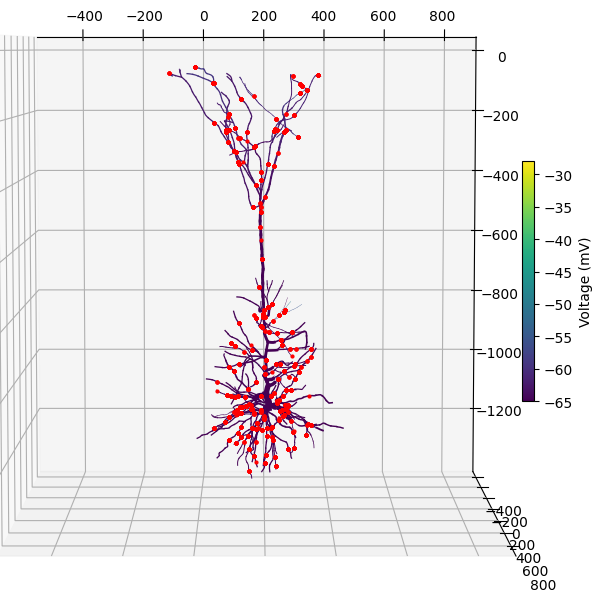

In [26]:
sim.analysis.plotShape(includePre=['L5_TTPC1_cAD'], includePost=['L5_TTPC1_cAD'], includeAxon=False, showSyns=True, showElectrodes=True,
    cvar= 'voltage', dist=0.6, elev=95, azim=-90, 
    axisLabels=True, synStyle='o', 
    clim= [-65, -28], showFig=1, synSize=2)

['L5_STPC', 'L5_TTPC1', 'L5_TTPC2', 'L5_UTPC']
Plotting 3D cell shape ...


(<Figure size 640x480 with 2 Axes>, {})

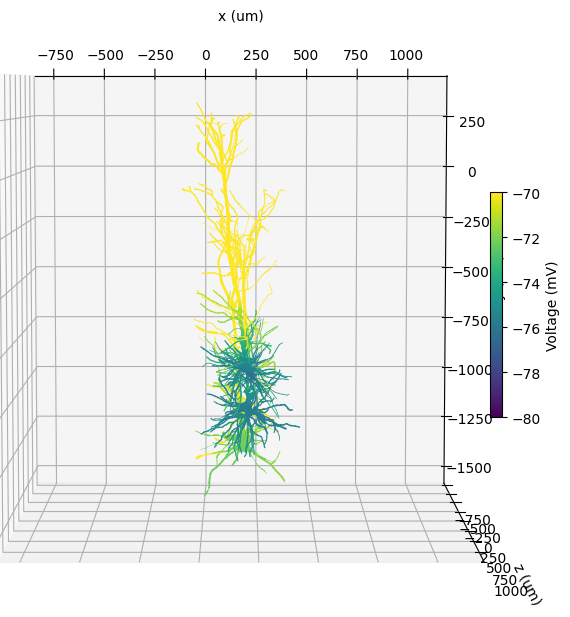

In [27]:
print(Epops[4:8])
sim.analysis.plotShape(includePre=[metype+'_cAD'for metype in Epops[4:8]],includePost=[metype+'_cAD'for metype in Epops[4:8]], includeAxon=False, showSyns=False, showElectrodes=False,
    cvar= 'voltage', dist=0.6, elev=95, azim=-90, 
    axisLabels=True, synStyle='o', 
    clim= [-80, -70], showFig=1, synSize=2)

Plotting 2D representation of network cell locations and connections...


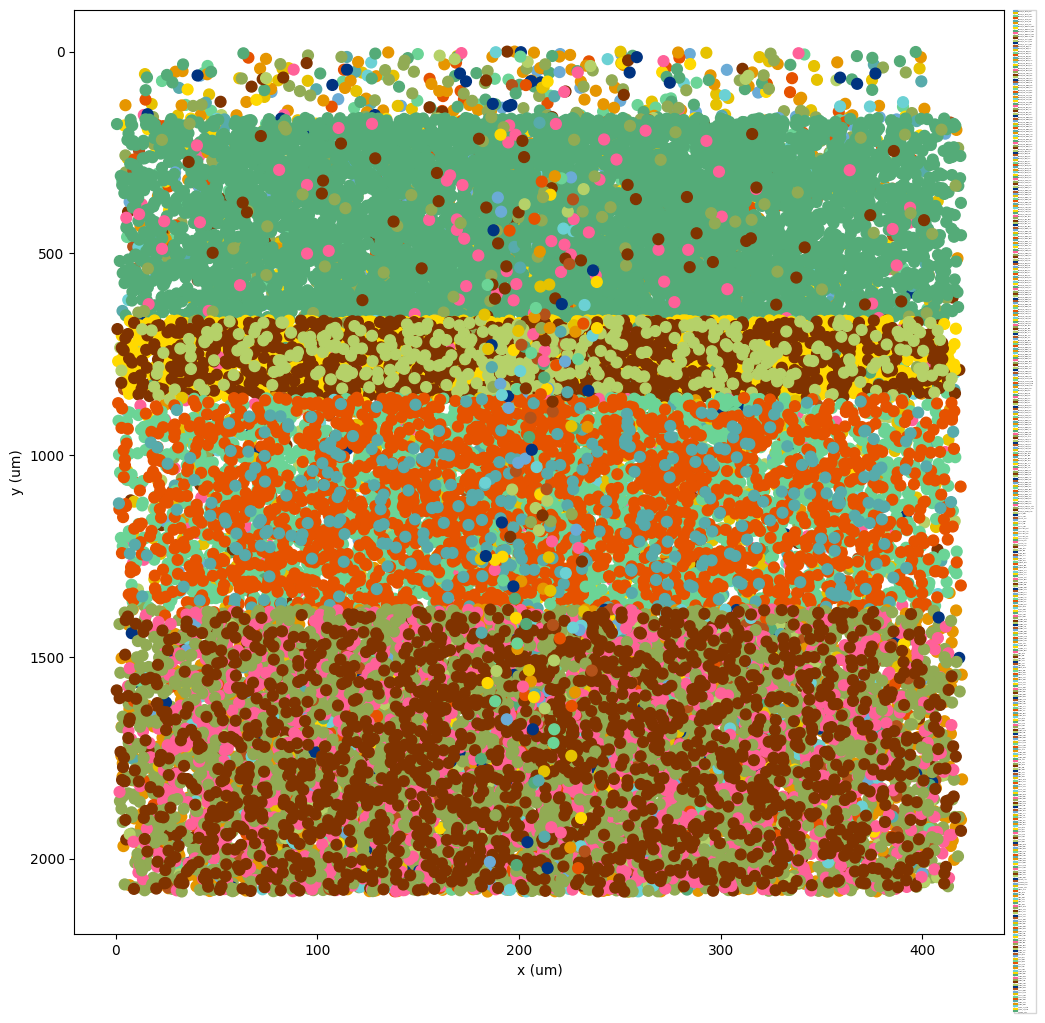

Plotting 2D representation of network cell locations and connections...


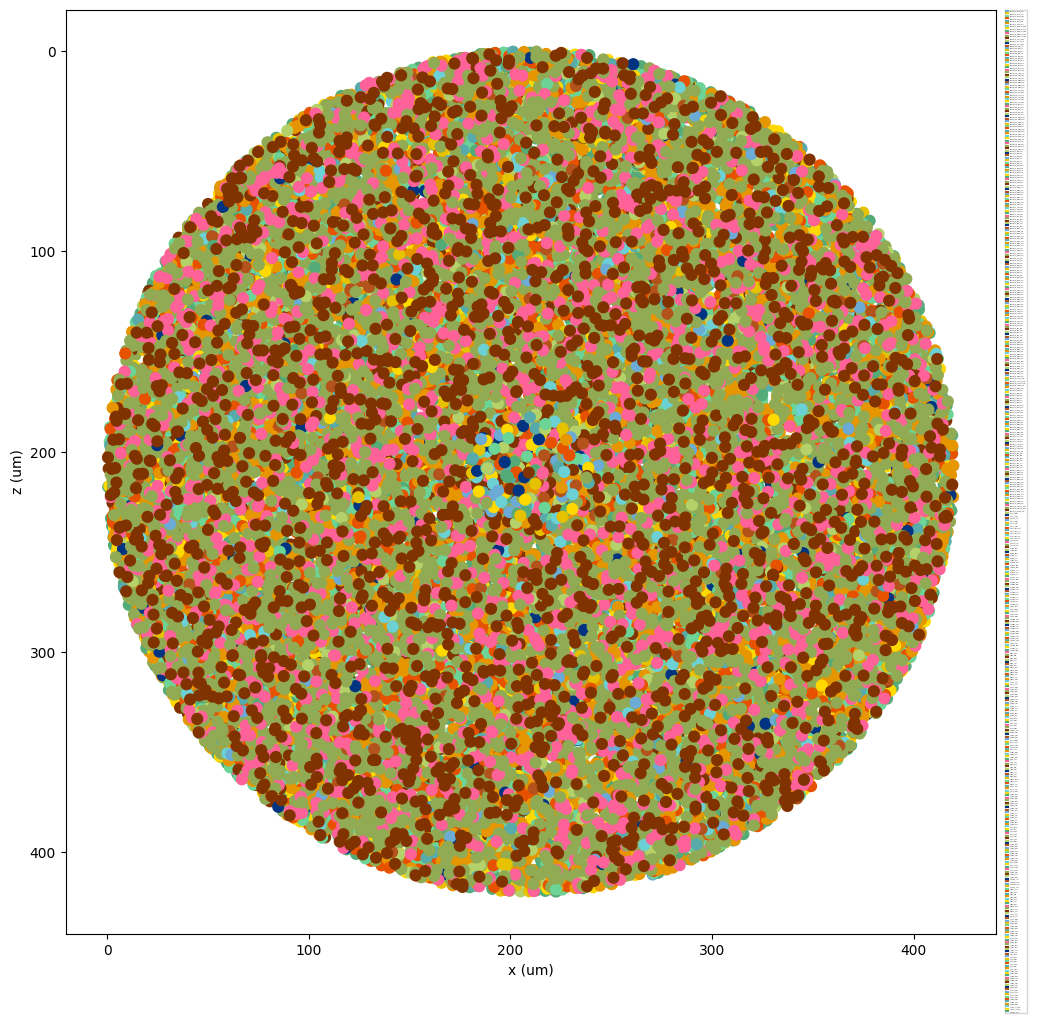

In [28]:
sim.analysis.plot2Dnet(**{'saveFig': True, 'showConns': False, 'fontSize':1});
sim.analysis.plot2Dnet(**{'view': 'xz','saveFig': True, 'showConns': False, 'fontSize':1});

Plotting 2D representation of network cell locations and connections...


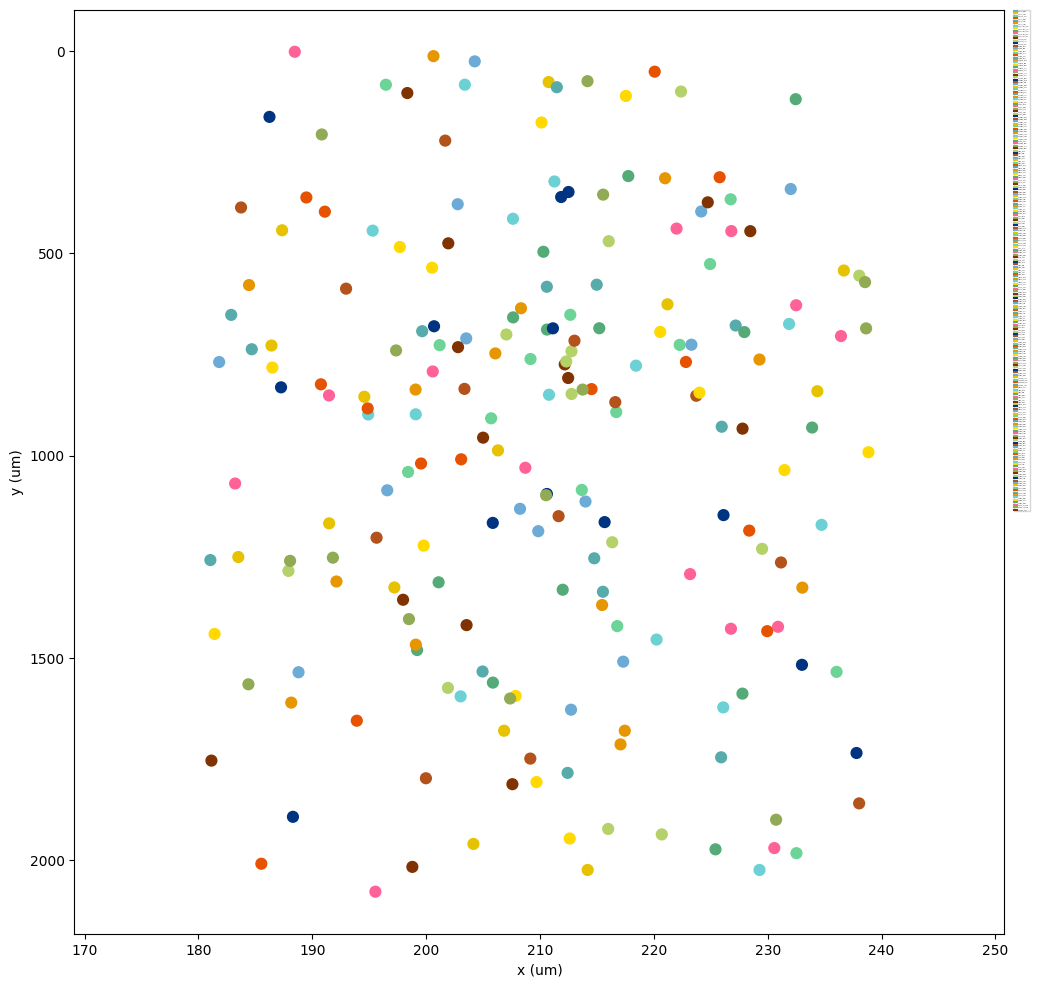

Plotting 2D representation of network cell locations and connections...


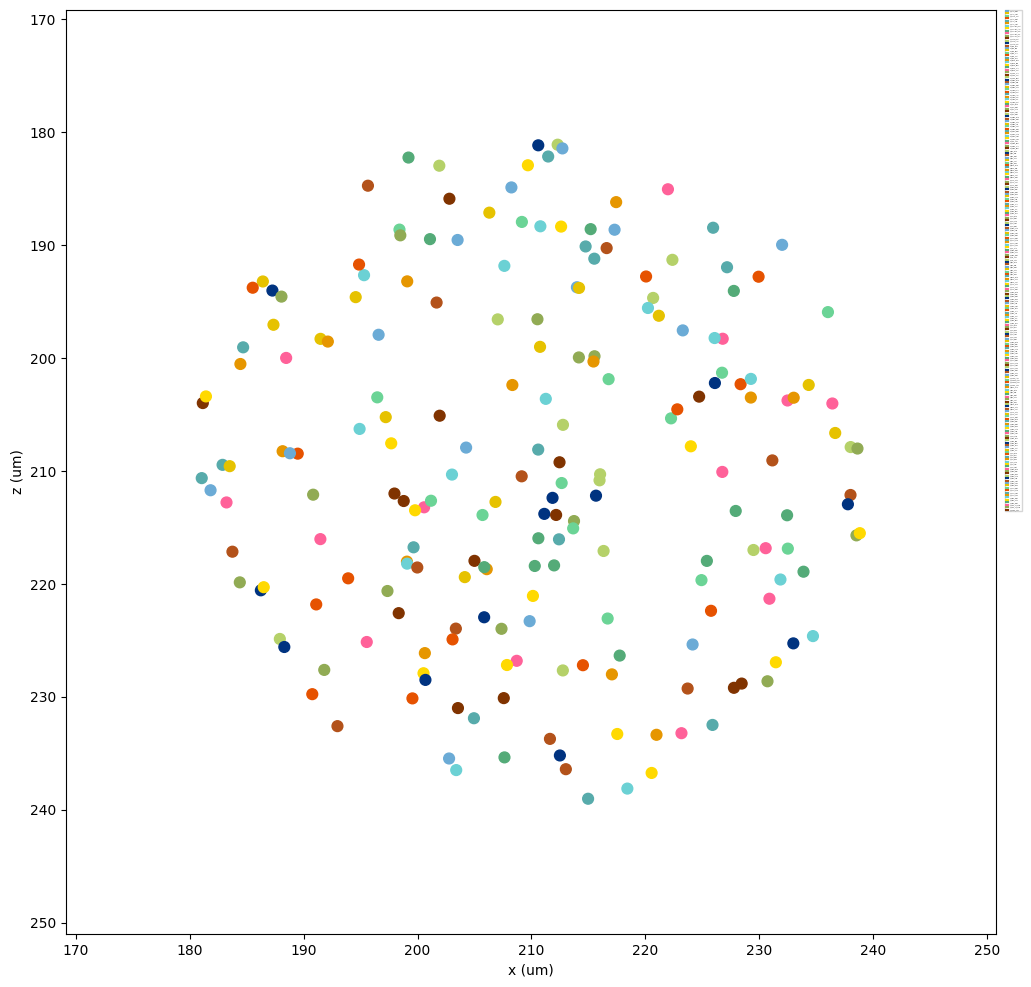

In [29]:
sim.analysis.plot2Dnet(**{'include': cfg.recordCells, 'saveFig': True, 'showConns': False, 'fontSize':1});
sim.analysis.plot2Dnet(**{'include': cfg.recordCells, 'view': 'xz','saveFig': True, 'showConns': False, 'fontSize':1});


Preparing spike data...
Plotting raster...
Preparing spike data...
Plotting raster...


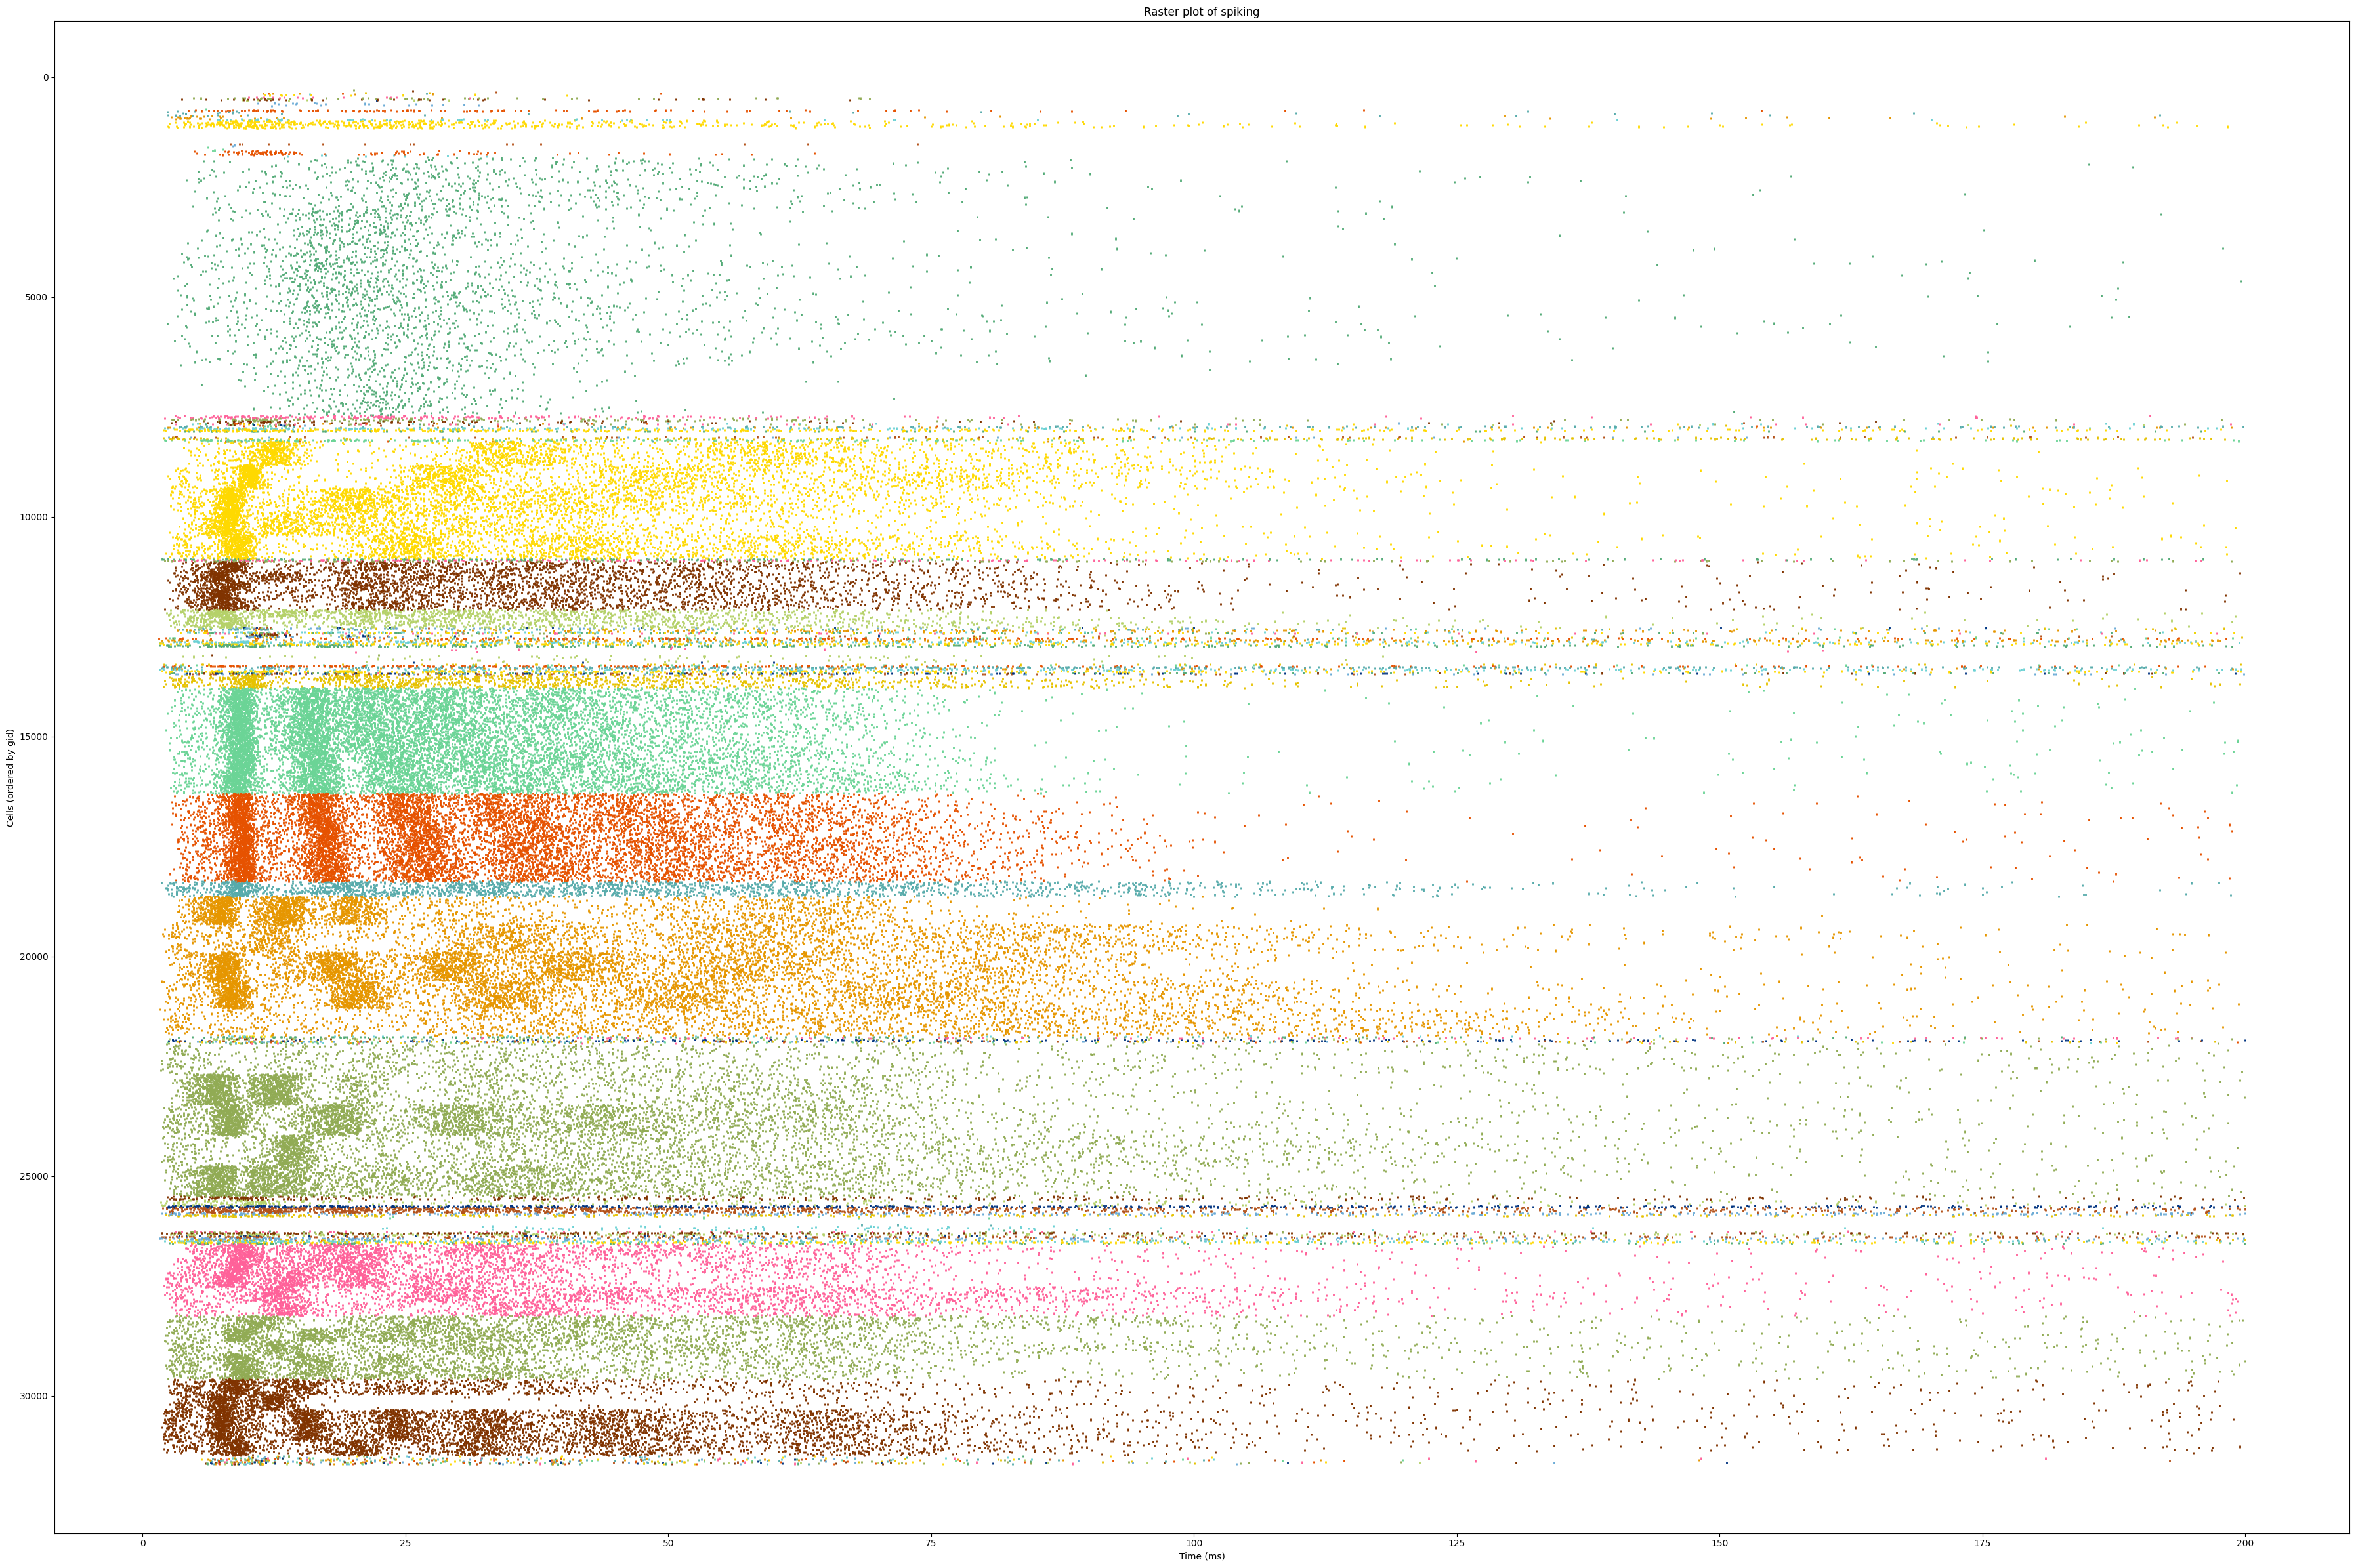

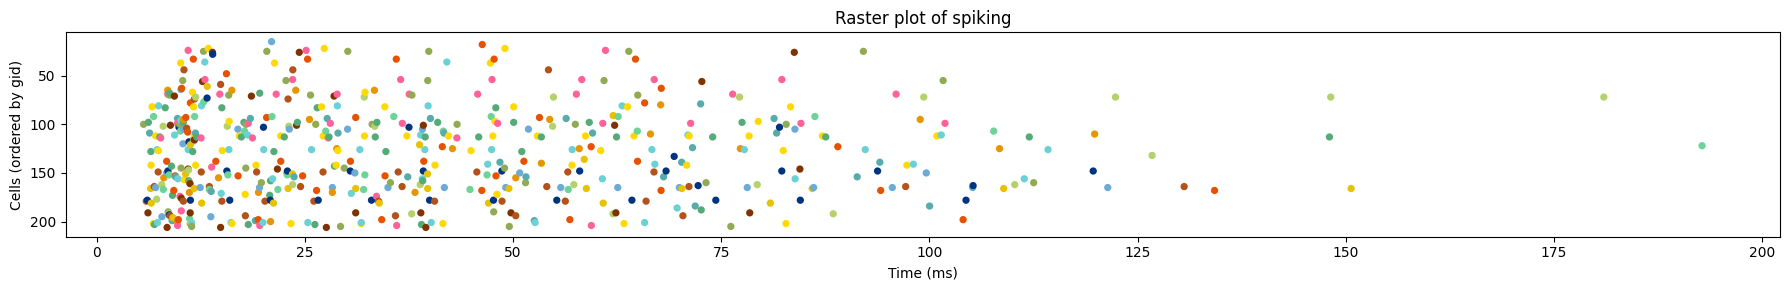

In [30]:
sim.analysis.plotRaster(figSize=(36, 24), fontSize=1, labels= None, popRates= False, orderInverse= True)
sim.analysis.plotRaster(include=cfg.recordCells,figSize=(18, 3), fontSize=48, lw=3, marker='o', markerSize=25, labels= None, popRates= False, orderInverse=True)

Plotting recorded cell traces ... trace


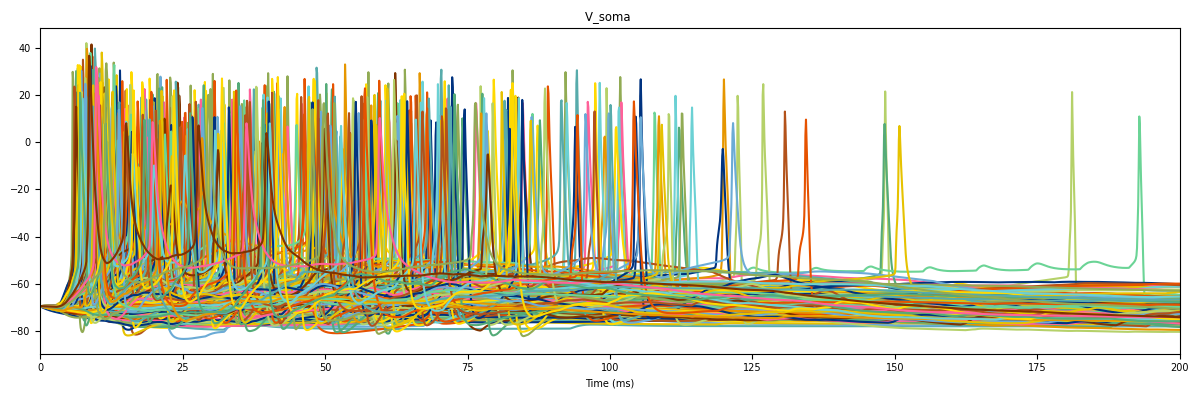

In [31]:
sim.analysis.plotTraces(include=cfg.recordCells, overlay=True, timeRange = [0, 200], oneFigPer='trace', figSize=(12, 4), fontSize=7, showFig=True, saveFig=True);

Preparing LFP data...
Plotting LFP time series...


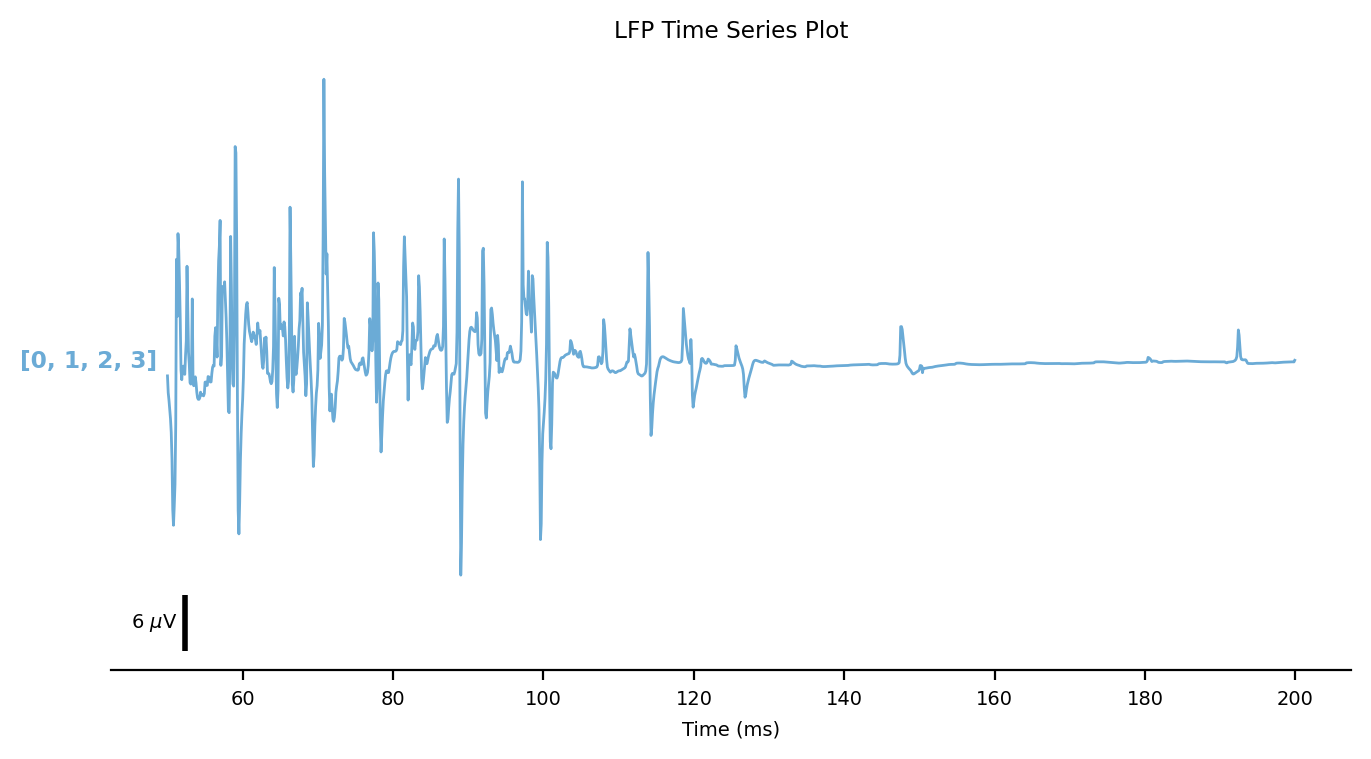

In [32]:
sim.analysis.plotLFP(**{'plots': ['timeSeries'], 'electrodes': [[0,1,2,3]], 'timeRange': [50, 200], 'figSize':(8, 4), 'saveData': True, 'showFig': True});

Preparing LFP data...
Plotting LFP time series...


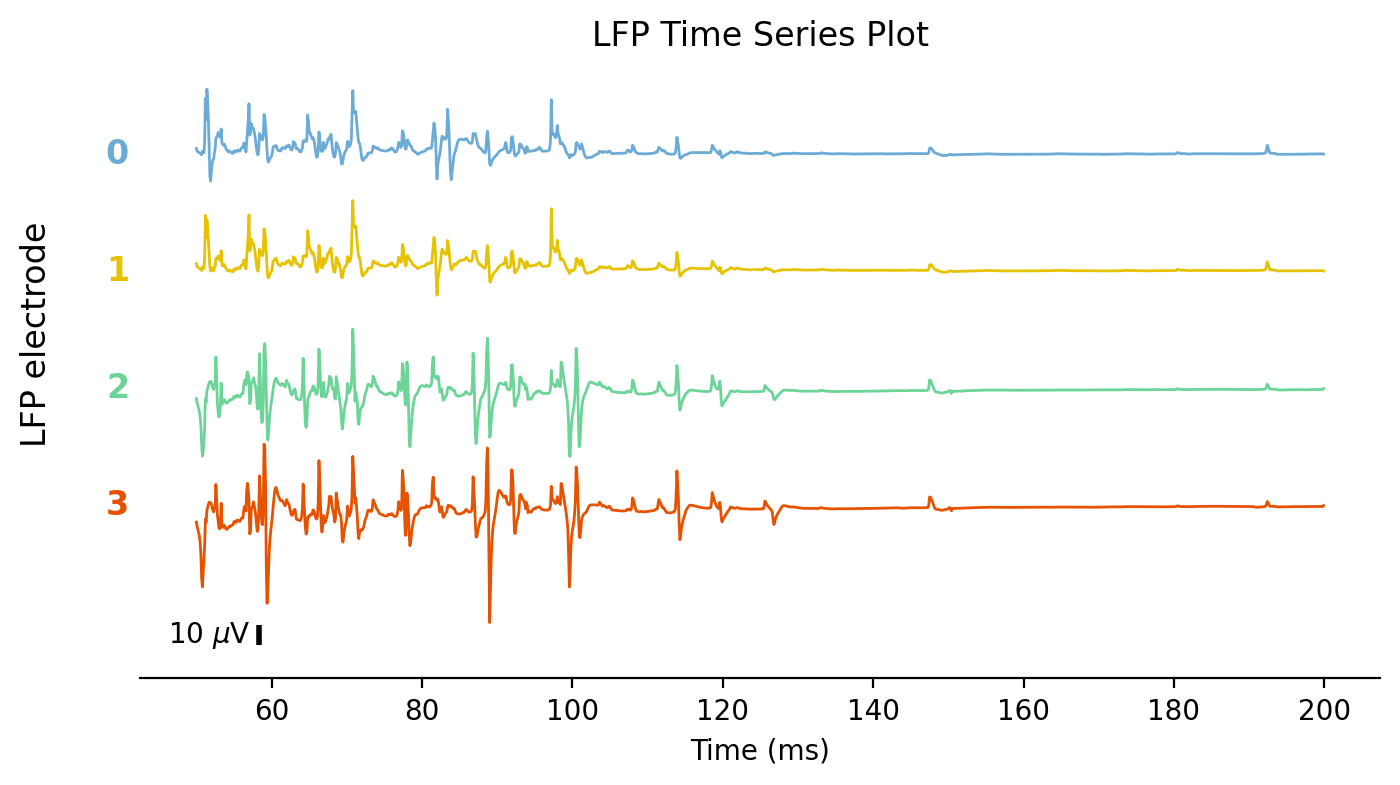

In [33]:
sim.analysis.plotLFP(**{'plots': ['timeSeries'], 'electrodes': [0,1,2,3], 'timeRange': [50, 200], 'figSize':(8, 4), 'saveData': True, 'showFig': True});

Preparing LFP data...
Preparing spectrogram data...
Plotting LFP spectrogram...


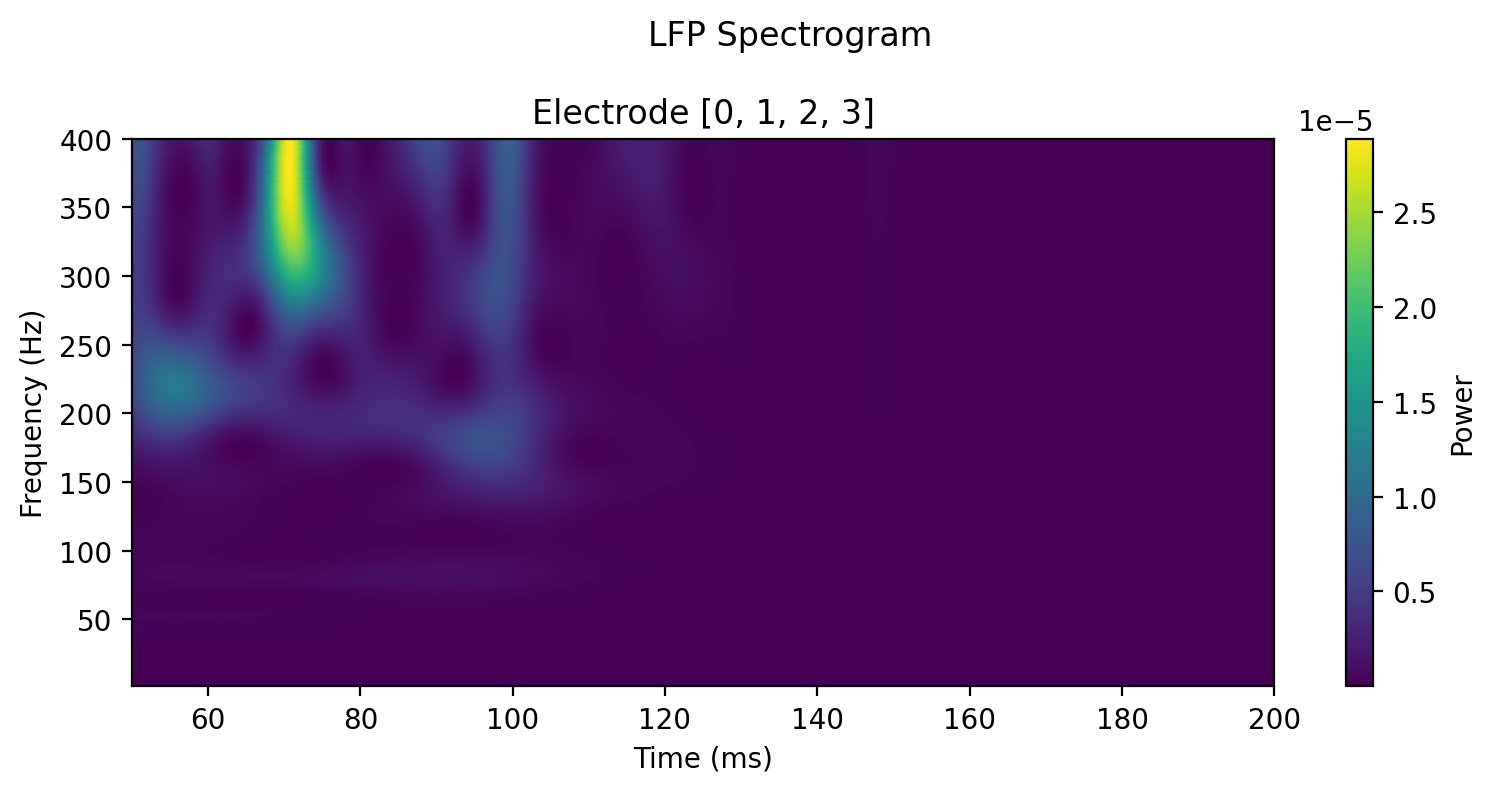

In [34]:
sim.analysis.plotLFP(**{'plots': ['spectrogram'], 'electrodes': [[ii for ii in range(4)]], 'maxFreq': 400, 'timeRange': [50, 200], 'figSize':(8, 4), 'saveData': True, 'showFig': True})

Preparing LFP data...
Preparing PSD data...
Plotting LFP power spectral density (PSD)...


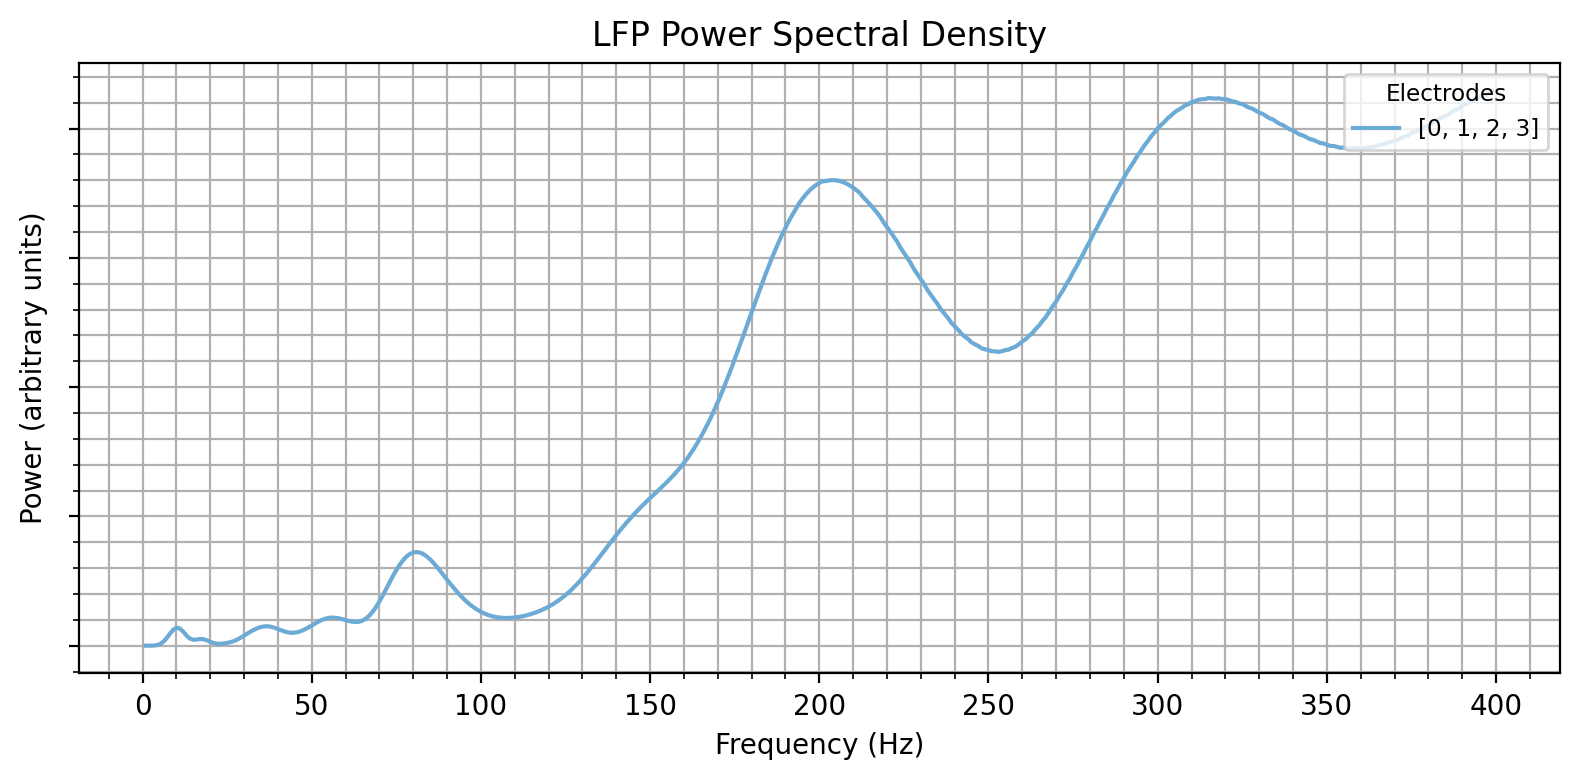

In [35]:
sim.analysis.plotLFP(**{'plots': ['PSD'], 'electrodes': [[ii for ii in range(4)]],'maxFreq': 400, 'timeRange': [50, 200], 'figSize':(8, 4), 'saveData': True, 'showFig': True})

In [36]:

#sim.analysis.plotTraces(include=cfg.recordCells, overlay=False, oneFigPer='trace', figSize=(18, 12), fontSize=9, saveFig=True)
# features = ['numConns','convergence']
# groups =['pop']
# for feat in features:
#    for group in groups:
#        sim.analysis.plotConn(includePre=['L1_DAC_cNA','L23_MC_cAC','L4_SS_cAD','L4_NBC_cNA','L5_TTPC2_cAD', 'L5_LBC_cNA', 'L6_TPC_L4_cAD', 'L6_LBC_cNA', 'ss_RTN_o', 'ss_RTN_m', 'ss_RTN_i', 'VPL_sTC', 'VPM_sTC', 'POm_sTC_s1'], includePost=['L1_DAC_cNA','L23_MC_cAC','L4_SS_cAD','L4_NBC_cNA','L5_TTPC2_cAD', 'L5_LBC_cNA', 'L6_TPC_L4_cAD', 'L6_LBC_cNA', 'ss_RTN_o', 'ss_RTN_m', 'ss_RTN_i', 'VPL_sTC', 'VPM_sTC', 'POm_sTC_s1'], feature=feat, groupBy=group, figSize=(24,24), saveFig=True, orderBy='gid', graphType='matrix', fontSize=18, saveData='../data/'+cfg.simLabel[0:9]+'/'+cfg.simLabel + '_' + group + '_' + feat+ '_matrix.json')

#sim.analysis.plotLFP(**{'plots': ['timeSeries'], 'electrodes': [0,1,2,3], 'timeRange': [0, 300], 'maxFreq':80, 'figSize': (16,8), 'saveFig': '../data/'+cfg.simLabel[0:9]+'/'+cfg.simLabel + '_' +'LFP1', 'showFig': False})
#sim.analysis.plotLFP(**{'plots': ['timeSeries'], 'electrodes': [4,5,6,7], 'timeRange': [0, 300], 'maxFreq':80, 'figSize': (16,8), 'saveFig': '../data/'+cfg.simLabel[0:9]+'/'+cfg.simLabel + '_' +'LFP2', 'showFig': False})
#sim.analysis.plotLFP(**{'plots': ['timeSeries'], 'electrodes': [8,9,10,11], 'timeRange': [0, 300], 'maxFreq':80, 'figSize': (16,8), 'saveFig': '../data/'+cfg.simLabel[0:9]+'/'+cfg.simLabel + '_' +'LFP3', 'showFig': False})

In [37]:
# sim.analysis.plotConn(includePre=cfg.recordCells, includePost=cfg.recordCells, feature='numConns', groupBy='cell', figSize=(12,12), saveFig=True, orderBy='gid', graphType='matrix', fontSize=18, saveData='../data/'+cfg.simLabel[0:9]+'/'+cfg.simLabel + '_matrix.json');